In [1]:
import json

import numpy as np

from pathlib import Path
from IPython.display import HTML, display
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

from joint import data

# put there the path to the results you want to show
FOLDER_3_WEIGHTED_EMB='joint/results/viz/eval_loss_both_slottype_full_we_large_recurrent_cell_lstm_attention_both_three_stages_intentextraction_word-emb___hyper:LABEL_EMB_SIZE=64,LSTM_SIZE=128,BATCH_SIZE=2,MAX_EPOCHS=100/huric_eb/modern'
FOLDER_3_BI_RNN='joint/results/viz/eval_loss_both_slottype_full_we_large_recurrent_cell_lstm_attention_both_three_stages___hyper:LABEL_EMB_SIZE=64,LSTM_SIZE=128,BATCH_SIZE=2,MAX_EPOCHS=100/huric_eb/modern'
FOLDER_2_WEIGHTED_EMB='joint/results/viz/eval_loss_both_slottype_full_we_large_recurrent_cell_lstm_attention_both_intentextraction_word-emb___hyper:LABEL_EMB_SIZE=64,LSTM_SIZE=128,BATCH_SIZE=2,MAX_EPOCHS=100/huric_eb/modern'
FOLDER_2_BI_RNN='joint/results/viz/eval_loss_both_slottype_full_we_large_recurrent_cell_lstm_attention_both___hyper:LABEL_EMB_SIZE=64,LSTM_SIZE=128,BATCH_SIZE=2,MAX_EPOCHS=100/huric_eb/modern'
FOLDER_2_ATIS='joint/results/eval_loss_both_slottype_full_we_large_recurrent_cell_lstm_attention_both___hyper:LABEL_EMB_SIZE=64,LSTM_SIZE=100,BATCH_SIZE=16,MAX_EPOCHS=10/atis'
FOLDER_3_ATIS='joint/results/eval_loss_both_slottype_full_we_large_recurrent_cell_lstm_attention_both_three_stages___hyper:LABEL_EMB_SIZE=64,LSTM_SIZE=100,BATCH_SIZE=16,MAX_EPOCHS=10/atis'
FOLDER_3_NLUBENCH='joint/results/eval_loss_both_slottype_full_we_large_recurrent_cell_lstm_attention_both_three_stages___hyper:LABEL_EMB_SIZE=64,LSTM_SIZE=100,BATCH_SIZE=16,MAX_EPOCHS=10/nlu-benchmark'

def load_json(folder, epoch=99):
    json_location = Path(folder) / 'json' / 'epoch_{}'.format(epoch) / 'prediction_fold_full.json'
    with open(json_location) as f:
        content = json.load(f)
    return content['samples']

def get_intent_attention_arrays(sentence_data):
    """returns true (lexical units) and pred attentions"""
    lexical_units = [0] * sentence_data['length']
    for lu in sentence_data['lexical_unit_ids']:
        lexical_units[lu - sentence_data['start_token_id']] = 1
    return lexical_units, sentence_data['intent_attentions']

#def get_bd_attention_arrays(sentence_data):
#    return sentence_data['words'], sentence_data['slots_pred']
   
def get_color(value):
    """Colors a cell by the value provided [0,1] if value is number, otherwise white"""
    
    if isinstance(value, str):
        return 'rgb(255,255,255)'
        print('str', value)
    else:
        v = "%.4f" %  (255 - value * 255)
        return 'rgb({}, 255,{})'.format(v, v)
    
def float_to_str(value):
    if isinstance(value, str):
        return value
    else:
        return "%.4f" % float(value)
    
def display_sequences(row_names, sequences):
    html_str = '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td><b>{}</b></td>'.format(row_name) +
            ''.join(['<td style="background-color: {};">{}</td>'.format(get_color(value), float_to_str(value)) for value in row])
            for row_name, row in zip(row_names, sequences)
        )
    )
    display(HTML(html_str))

def display_align(row_labels, col_labels, values):
    html_str = '<table><tr>{}</tr><tr>{}</tr></table>'.format(
        # the headers
        ''.join(['<td>{}</td>'.format(t) for t in [''] + row_labels]),
        # the body
        '</tr><tr>'.join(
            '<td>{}</td>'.format(col_labels[row_idx]) +
            ''.join(['<td style="background-color: {};">{}</td>'.format(get_color(value), float_to_str(value)) for value in row])
            for row_idx, row in enumerate(values)
        )
    )
    display(HTML(html_str))

def display_all(samples, display_bd=True, display_ac=True, display_slots=True, max_show=None):
    for idx, sample in enumerate(samples):
        print('true:', sample['intent_true'], 'pred:', sample['intent_pred'])
        attentions_true, attentions_pred = get_intent_attention_arrays(sample)
        display_sequences(['words', 'lexical_unit','attention_intent', 'slots_true', 'slots_pred'],
                          [sample['words'], attentions_true, attentions_pred, sample['slots_true'], sample['slots_pred']])
        bd = data.slots_to_iob_only(sample['slots_pred'])
        ac = data.slots_to_types_only(sample['slots_pred'])
        if display_bd:
            display_align(sample['words'], bd, sample['bd_attentions'])
        bd_and_words = ['{}+{}'.format(b, w) for b, w in zip(bd, sample['words'])]
        if display_ac:
            display_align(bd_and_words, ac, sample['ac_attentions'])
        if display_slots:
            display_align(sample['words'], sample['slots_pred'], sample['slots_attentions'])
        # don't make the browser crash with all those tables
        if max_show and idx > max_show:
            return

def align_accuracy_argmax(samples):
    true_lexical_units = [s['lexical_unit_ids'][0] - 1 for s in samples]
    pred_lexical_units = [np.argmax(s['intent_attentions']) for s in samples]
    compared = [1 if t == p else 0 for t, p in zip(true_lexical_units, pred_lexical_units)]
    return sum(compared) / len(compared)

        
def align_score(samples):
    true_lexical_units = []
    for s in samples:
        true_s = [1 if idx + 1 in s['lexical_unit_ids'] else 0 for idx in range(s['length'])]
        #print('t', true_s)
        true_lexical_units.extend(true_s)
    print(np.shape(true_lexical_units))
    
    precisions_vs_k = {}
    recalls_vs_k = {}
    f1_vs_k = {}
    
    for how_many in range(1, 10):
        pred_lexical_units = []
        for s in samples:
            padded_intent_att = np.pad(s['intent_attentions'], (0, 50 - s['length']), 'constant')
            pred_k_indexes = np.argpartition(padded_intent_att, -how_many)[-how_many:]
            #print(pred_k_indexes)
            pred_k = [1 if idx in pred_k_indexes else 0 for idx in range(s['length'])]
            #print(pred_k)
            pred_lexical_units.extend(pred_k)
        #print('true', true_lexical_units[:30])
        #print('pred', pred_lexical_units[:30])
        p, r, f1, support = precision_recall_fscore_support(true_lexical_units, pred_lexical_units, average='binary')
        #print('k=', how_many, 'p=', p, 'r=', r, 'f1=', f1, 'support=', support)
        precisions_vs_k[how_many] = p # with average='binary' the scores are for the 1 label, the interesting one
        recalls_vs_k[how_many] = r
        f1_vs_k[how_many] = f1
        
    display_alignment_vs_k(precisions_vs_k, recalls_vs_k, f1_vs_k)
    return precisions_vs_k, recalls_vs_k, f1_vs_k

def display_alignment_vs_k(precisions, recalls, f1s):
    plt.clf()
    plt.plot(precisions.keys(), precisions.values(), label='precision')
    plt.plot(recalls.keys(), recalls.values(), label='recall')
    plt.xlabel('k-top')
    plt.legend(['precision', 'recall'], loc='lower right')
    plt.show()


lexical_unit score: 0.5740740740740741
(694,)


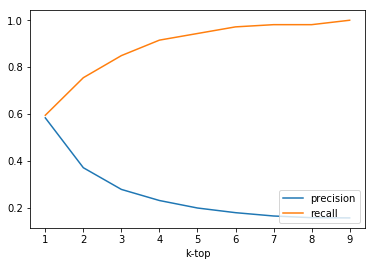

true: Inspecting pred: Inspecting


words,check,the,toilet,paper
lexical_unit,1.0000,0.0000,0.0000,0.0000
attention_intent,0.9959,0.0000,0.0002,0.0000
slots_true,O,B-Ground,I-Ground,I-Ground
slots_pred,O,B-Phenomenon,I-Phenomenon,I-Phenomenon


,check,the,toilet,paper
O,0.2838,0.0968,0.2879,0.3314
B-_,0.0624,0.0183,0.0331,0.8863
I-_,0.0106,0.0072,0.0125,0.9696
I-_,0.0029,0.0043,0.0081,0.9847


,O+check,B-_+the,I-_+toilet,I-_+paper
O,0.2813,0.1087,0.1528,0.4572
Phenomenon,0.0987,0.0710,0.1053,0.7250
Phenomenon,0.0941,0.0755,0.1023,0.7281
Phenomenon,0.0862,0.0698,0.1016,0.7425


true: Bringing pred: Taking


words,can,you,please,take,out,the,garbage
lexical_unit,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
attention_intent,0.0010,0.0002,0.0012,0.6455,0.0403,0.0001,0.2656
slots_true,O,B-Agent,O,O,B-Goal,B-Theme,I-Theme
slots_pred,O,B-Agent,O,O,B-Theme,I-Theme,I-Theme


,can,you,please,take,out,the,garbage
O,0.0016,0.0006,0.0012,0.0883,0.7540,0.1022,0.0521
B-_,0.0197,0.0144,0.0094,0.2494,0.6493,0.0128,0.0450
O,0.0055,0.0019,0.0030,0.0866,0.7959,0.0238,0.0834
O,0.0026,0.0010,0.0026,0.0901,0.8348,0.0293,0.0396
B-_,0.0130,0.0163,0.0059,0.2512,0.5684,0.0241,0.1211
I-_,0.0000,0.0000,0.0000,0.0001,0.0151,0.0156,0.9691
I-_,0.0001,0.0000,0.0000,0.0002,0.0292,0.0199,0.9506


,O+can,B-_+you,O+please,O+take,B-_+out,I-_+the,I-_+garbage
O,0.1089,0.0547,0.0847,0.1023,0.2379,0.1542,0.2573
Agent,0.1224,0.0772,0.0407,0.0439,0.0699,0.0537,0.5923
O,0.1478,0.0701,0.0714,0.0898,0.1744,0.1298,0.3167
O,0.1483,0.0803,0.0743,0.0971,0.1821,0.1362,0.2818
Theme,0.1333,0.0795,0.0528,0.0601,0.0817,0.0581,0.5345
Theme,0.1196,0.0953,0.0403,0.0505,0.0962,0.0727,0.5254
Theme,0.1165,0.0913,0.0361,0.0444,0.1044,0.0778,0.5295


true: Motion pred: Change_operational_state


words,go,next,to,the,tv,set
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0573,0.0037,0.0534,0.0000,0.6043,0.2782
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,O,O,O,O,O


,go,next,to,the,tv,set
O,0.0468,0.0736,0.4746,0.0288,0.1090,0.2672
O,0.0465,0.0657,0.2766,0.0281,0.0813,0.5019
O,0.0008,0.0108,0.2316,0.0066,0.0121,0.7380
O,0.0004,0.0068,0.2222,0.0049,0.0077,0.7581
O,0.0004,0.0107,0.2754,0.0047,0.0098,0.6990
O,0.0003,0.0050,0.2568,0.0035,0.0050,0.7294


,O+go,O+next,O+to,O+the,O+tv,O+set
O,0.1166,0.1040,0.2403,0.0837,0.1411,0.3143
O,0.0983,0.0771,0.1813,0.0661,0.1318,0.4454
O,0.0889,0.0597,0.1963,0.0598,0.0806,0.5146
O,0.1044,0.0794,0.2350,0.0772,0.0793,0.4248
O,0.0973,0.0696,0.2177,0.0699,0.0828,0.4627
O,0.0903,0.0643,0.2109,0.0655,0.0795,0.4896


true: Taking pred: Taking


words,grab,the,book,with,the,blue,cover
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.8802,0.0000,0.0000,0.1098,0.0000,0.0057,0.0000
slots_true,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme
slots_pred,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme


,grab,the,book,with,the,blue,cover
O,0.4732,0.1499,0.2234,0.1247,0.0185,0.0085,0.0018
B-_,0.4914,0.0829,0.2469,0.1331,0.0180,0.0178,0.0098
I-_,0.3427,0.1103,0.3204,0.1587,0.0238,0.0269,0.0172
I-_,0.0069,0.0679,0.2612,0.3144,0.0919,0.0555,0.2022
I-_,0.0243,0.1069,0.3325,0.3184,0.0750,0.0587,0.0842
I-_,0.0754,0.1209,0.3828,0.2683,0.0545,0.0528,0.0452
I-_,0.0555,0.1147,0.3705,0.2850,0.0600,0.0542,0.0602


,O+grab,B-_+the,I-_+book,I-_+with,I-_+the,I-_+blue,I-_+cover
O,0.1455,0.0818,0.2495,0.1950,0.0727,0.0924,0.1632
Theme,0.0946,0.0817,0.1769,0.1720,0.0587,0.0934,0.3227
Theme,0.0796,0.0659,0.1608,0.1631,0.0657,0.0930,0.3718
Theme,0.0846,0.0678,0.1615,0.1657,0.0627,0.0907,0.3669
Theme,0.0777,0.0714,0.1485,0.1517,0.0703,0.0874,0.3930
Theme,0.0746,0.0702,0.1503,0.1540,0.0678,0.0874,0.3956
Theme,0.0746,0.0707,0.1473,0.1519,0.0674,0.0856,0.4024


true: Motion pred: Motion


words,move,to,the,left,of,the,table
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.4483,0.4666,0.0001,0.0049,0.0003,0.0001,0.0520
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,move,to,the,left,of,the,table
O,0.0634,0.3324,0.0370,0.2681,0.0783,0.1050,0.1158
B-_,0.0142,0.1332,0.0246,0.1572,0.0566,0.0481,0.5661
I-_,0.0036,0.0461,0.0098,0.0776,0.0297,0.0216,0.8116
I-_,0.0033,0.0520,0.0102,0.0795,0.0271,0.0211,0.8068
I-_,0.0038,0.0478,0.0103,0.0795,0.0280,0.0206,0.8100
I-_,0.0047,0.0413,0.0103,0.0737,0.0261,0.0207,0.8232
I-_,0.0043,0.0442,0.0098,0.0754,0.0247,0.0196,0.8221


,O+move,B-_+to,I-_+the,I-_+left,I-_+of,I-_+the,I-_+table
O,0.1212,0.1518,0.0989,0.1809,0.1200,0.1073,0.2199
Goal,0.0631,0.0875,0.0564,0.0978,0.0767,0.0625,0.5559
Goal,0.0821,0.1336,0.0730,0.1464,0.1027,0.0829,0.3793
Goal,0.0835,0.1364,0.0674,0.1507,0.1013,0.0773,0.3834
Goal,0.0869,0.1352,0.0737,0.1463,0.1038,0.0825,0.3716
Goal,0.0864,0.1368,0.0699,0.1510,0.1034,0.0792,0.3732
Goal,0.0842,0.1316,0.0694,0.1463,0.1023,0.0785,0.3876


true: Taking pred: Taking


words,take,the,magazine,that,is,in,the,bathroom
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.4532,0.0001,0.0001,0.0048,0.5044,0.0050,0.0001,0.0000
slots_true,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme
slots_pred,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme


,take,the,magazine,that,is,in,the,bathroom
O,0.7196,0.1662,0.0587,0.0189,0.0297,0.0028,0.0025,0.0016
B-_,0.7050,0.0771,0.0559,0.0297,0.1098,0.0072,0.0082,0.0072
I-_,0.5383,0.0963,0.1044,0.0611,0.1778,0.0070,0.0079,0.0074
I-_,0.2543,0.1122,0.1387,0.1027,0.3752,0.0055,0.0056,0.0059
I-_,0.0622,0.0651,0.0911,0.1095,0.6646,0.0038,0.0021,0.0017
I-_,0.0013,0.0030,0.0174,0.1243,0.8476,0.0057,0.0003,0.0004
I-_,0.0013,0.0030,0.0190,0.1291,0.8421,0.0050,0.0003,0.0003
I-_,0.0013,0.0032,0.0191,0.1286,0.8421,0.0052,0.0003,0.0002


,O+take,B-_+the,I-_+magazine,I-_+that,I-_+is,I-_+in,I-_+the,I-_+bathroom
O,0.1066,0.0530,0.2017,0.2282,0.2334,0.0710,0.0481,0.0580
Theme,0.1021,0.0712,0.1737,0.2263,0.2058,0.0481,0.0418,0.1309
Theme,0.0792,0.0652,0.1683,0.2505,0.2316,0.0579,0.0424,0.1049
Theme,0.0848,0.0687,0.1682,0.2519,0.2284,0.0544,0.0403,0.1033
Theme,0.0891,0.0800,0.1539,0.2376,0.2172,0.0610,0.0460,0.1151
Theme,0.0921,0.0796,0.1542,0.2273,0.2125,0.0594,0.0464,0.1284
Theme,0.0898,0.0847,0.1477,0.2328,0.2173,0.0681,0.0487,0.1109
Theme,0.0867,0.0784,0.1549,0.2479,0.2186,0.0592,0.0416,0.1127


true: Motion pred: Motion


words,go,straight,to,the,living,room
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.1346,0.7311,0.1255,0.0000,0.0000,0.0013
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,go,straight,to,the,living,room
O,0.1247,0.3969,0.3084,0.0583,0.0599,0.0519
B-_,0.0181,0.1563,0.2786,0.0679,0.0480,0.4312
I-_,0.0005,0.0148,0.5869,0.0349,0.0148,0.3480
I-_,0.0008,0.0147,0.5872,0.0371,0.0188,0.3414
I-_,0.0011,0.0246,0.5383,0.0396,0.0212,0.3752
I-_,0.0010,0.0220,0.5491,0.0394,0.0199,0.3686


,O+go,B-_+straight,I-_+to,I-_+the,I-_+living,I-_+room
O,0.1290,0.1520,0.2836,0.1653,0.1200,0.1501
Goal,0.0718,0.0813,0.1672,0.1080,0.0787,0.4930
Goal,0.0842,0.1075,0.2395,0.1485,0.0948,0.3255
Goal,0.0934,0.1150,0.2415,0.1595,0.0994,0.2912
Goal,0.0905,0.1173,0.2267,0.1515,0.0992,0.3148
Goal,0.0908,0.1141,0.2211,0.1497,0.0993,0.3249


true: Searching pred: Searching


words,please,find,the,bed
lexical_unit,0.0000,1.0000,0.0000,0.0000
attention_intent,0.0236,0.0021,0.0022,0.0980
slots_true,O,O,B-Phenomenon,I-Phenomenon
slots_pred,O,O,B-Phenomenon,I-Phenomenon


,please,find,the,bed
O,0.0720,0.5692,0.2271,0.1317
O,0.0981,0.6084,0.2275,0.0660
B-_,0.0445,0.6741,0.0747,0.2068
I-_,0.0097,0.2257,0.0564,0.7082


,O+please,O+find,B-_+the,I-_+bed
O,0.2720,0.3151,0.1747,0.2382
O,0.2759,0.3576,0.1753,0.1912
Phenomenon,0.1762,0.1644,0.1261,0.5333
Phenomenon,0.1339,0.1873,0.1481,0.5307


true: Motion pred: Motion


words,go,to,living,room
lexical_unit,1.0000,0.0000,0.0000,0.0000
attention_intent,0.5006,0.4667,0.0000,0.0049
slots_true,O,B-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal


,go,to,living,room
O,0.2685,0.4869,0.1344,0.1101
B-_,0.0226,0.1938,0.0418,0.7418
I-_,0.0066,0.1862,0.0383,0.7689
I-_,0.0067,0.1835,0.0381,0.7717


,O+go,B-_+to,I-_+living,I-_+room
O,0.2480,0.2962,0.1860,0.2697
Goal,0.1114,0.1532,0.0938,0.6416
Goal,0.1604,0.2531,0.1333,0.4533
Goal,0.1623,0.2528,0.1341,0.4508


true: Bringing pred: Bringing


words,bring,me,a,fork,from,the,press
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.7307,0.1973,0.0032,0.0594,0.0002,0.0000,0.0068
slots_true,O,B-Beneficiary,B-Theme,I-Theme,B-Source,I-Source,I-Source
slots_pred,O,B-Beneficiary,B-Theme,I-Theme,B-Source,I-Source,I-Source


,bring,me,a,fork,from,the,press
O,0.0088,0.5441,0.1808,0.2004,0.0569,0.0064,0.0025
B-_,0.0048,0.8479,0.0428,0.0903,0.0116,0.0012,0.0015
B-_,0.0376,0.4327,0.0940,0.3384,0.0536,0.0081,0.0356
I-_,0.0021,0.0806,0.0971,0.4375,0.1099,0.0341,0.2388
B-_,0.0001,0.0029,0.0009,0.0033,0.9703,0.0018,0.0207
I-_,0.0000,0.0005,0.0001,0.0007,0.9877,0.0003,0.0107
I-_,0.0000,0.0006,0.0000,0.0007,0.9821,0.0003,0.0163


,O+bring,B-_+me,B-_+a,I-_+fork,B-_+from,I-_+the,I-_+press
O,0.0581,0.1226,0.0428,0.2875,0.3359,0.0576,0.0955
Beneficiary,0.0385,0.1241,0.0407,0.2007,0.3699,0.0506,0.1754
Theme,0.0407,0.1154,0.0437,0.1619,0.3622,0.0484,0.2277
Theme,0.0260,0.1121,0.0304,0.1576,0.3664,0.0419,0.2656
Source,0.0288,0.1014,0.0323,0.1328,0.3648,0.0372,0.3027
Source,0.0273,0.0998,0.0335,0.1306,0.3632,0.0421,0.3035
Source,0.0257,0.1101,0.0323,0.1477,0.3450,0.0448,0.2944


true: Bringing pred: Bringing


words,i,would,like,some,loo,roll,can,you,get,me,some,loo,roll
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0001,0.0030,0.0017,0.0007,0.0000,0.2585,0.0001,0.0000,0.2152,0.2584,0.0007,0.0000,0.2585
slots_true,O,O,O,O,O,O,O,B-Agent,O,B-Beneficiary,B-Theme,I-Theme,I-Theme
slots_pred,O,O,O,O,O,O,O,B-Agent,O,B-Beneficiary,B-Theme,I-Theme,B-Goal


,i,would,like,some,loo,roll,can,you,get,me,some,loo,roll
O,0.0001,0.0001,0.0001,0.0001,0.0005,0.0021,0.0047,0.0020,0.0501,0.6209,0.0828,0.0522,0.1845
O,0.0002,0.0002,0.0002,0.0001,0.0011,0.0039,0.0062,0.0032,0.0641,0.5412,0.0996,0.0669,0.2131
O,0.0001,0.0002,0.0002,0.0002,0.0011,0.0033,0.0050,0.0031,0.0598,0.5861,0.1053,0.0597,0.1759
O,0.0001,0.0002,0.0002,0.0001,0.0014,0.0041,0.0055,0.0035,0.0759,0.5622,0.1121,0.0729,0.1617
O,0.0001,0.0002,0.0002,0.0001,0.0011,0.0031,0.0041,0.0033,0.0672,0.6509,0.1044,0.0605,0.1048
O,0.0001,0.0001,0.0001,0.0001,0.0007,0.0020,0.0031,0.0024,0.0505,0.6996,0.0918,0.0528,0.0967
O,0.0001,0.0002,0.0002,0.0002,0.0010,0.0029,0.0050,0.0034,0.0576,0.6141,0.1139,0.0646,0.1368
B-_,0.0004,0.0008,0.0011,0.0008,0.0013,0.0039,0.0143,0.0081,0.0813,0.5590,0.1063,0.0618,0.1610
O,0.0001,0.0001,0.0001,0.0001,0.0006,0.0021,0.0058,0.0039,0.0602,0.6723,0.0858,0.0406,0.1283
B-_,0.0001,0.0001,0.0001,0.0001,0.0001,0.0005,0.0018,0.0011,0.0192,0.9340,0.0149,0.0108,0.0173


,O+i,O+would,O+like,O+some,O+loo,O+roll,O+can,B-_+you,O+get,B-_+me,B-_+some,I-_+loo,B-_+roll
O,0.0314,0.0226,0.0230,0.0217,0.0389,0.0685,0.1411,0.0361,0.0844,0.1831,0.0772,0.0830,0.1890
O,0.0391,0.0270,0.0278,0.0247,0.0470,0.0769,0.1290,0.0405,0.0871,0.1552,0.0816,0.0912,0.1730
O,0.0300,0.0231,0.0244,0.0226,0.0349,0.0613,0.1269,0.0345,0.0770,0.1889,0.0725,0.0738,0.2300
O,0.0332,0.0239,0.0250,0.0228,0.0392,0.0684,0.1307,0.0362,0.0827,0.1735,0.0785,0.0855,0.2005
O,0.0357,0.0249,0.0262,0.0233,0.0415,0.0713,0.1314,0.0380,0.0835,0.1694,0.0790,0.0840,0.1918
O,0.0283,0.0228,0.0241,0.0224,0.0328,0.0575,0.1267,0.0336,0.0761,0.1972,0.0708,0.0693,0.2384
O,0.0283,0.0227,0.0237,0.0225,0.0343,0.0590,0.1285,0.0345,0.0783,0.1941,0.0733,0.0753,0.2254
Agent,0.0357,0.0310,0.0331,0.0269,0.0315,0.0445,0.1172,0.0327,0.0592,0.1514,0.0532,0.0535,0.3302
O,0.0376,0.0258,0.0265,0.0224,0.0430,0.0747,0.1343,0.0381,0.0861,0.1547,0.0813,0.0915,0.1839
Beneficiary,0.0382,0.0344,0.0361,0.0307,0.0363,0.0483,0.1141,0.0358,0.0643,0.1484,0.0542,0.0536,0.3056


true: Placing pred: Placing


words,can,you,put,the,detergent,in,the,washing,machine
lexical_unit,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0001,0.0000,0.8593,0.0000,0.1321,0.0009,0.0000,0.0014,0.0002
slots_true,O,B-Agent,O,B-Theme,I-Theme,B-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Agent,O,B-Theme,I-Theme,B-Goal,I-Goal,I-Goal,I-Goal


,can,you,put,the,detergent,in,the,washing,machine
O,0.0025,0.0027,0.3170,0.0703,0.4801,0.0231,0.0268,0.0387,0.0388
B-_,0.0166,0.0248,0.6005,0.1022,0.1931,0.0094,0.0072,0.0147,0.0316
O,0.0073,0.0113,0.1718,0.0885,0.5543,0.0238,0.0155,0.0253,0.1021
B-_,0.0119,0.0226,0.4046,0.0366,0.4174,0.0145,0.0124,0.0226,0.0575
I-_,0.0223,0.0208,0.3108,0.0574,0.4647,0.0161,0.0124,0.0232,0.0722
B-_,0.0007,0.0003,0.0004,0.0002,0.0237,0.2649,0.0071,0.0018,0.7010
I-_,0.0003,0.0002,0.0003,0.0001,0.0529,0.1300,0.0084,0.0032,0.8045
I-_,0.0004,0.0002,0.0004,0.0001,0.0320,0.1464,0.0065,0.0025,0.8115
I-_,0.0003,0.0002,0.0003,0.0001,0.0359,0.1592,0.0065,0.0021,0.7955


,O+can,B-_+you,O+put,B-_+the,I-_+detergent,B-_+in,I-_+the,I-_+washing,I-_+machine
O,0.0731,0.0466,0.0877,0.0460,0.2982,0.1681,0.0784,0.0816,0.1203
Agent,0.1164,0.0461,0.0483,0.0378,0.1471,0.0898,0.0541,0.0511,0.4094
O,0.1150,0.0539,0.1005,0.0585,0.2356,0.1422,0.0811,0.0932,0.1201
Theme,0.1187,0.0527,0.0627,0.0421,0.1446,0.0793,0.0502,0.0561,0.3936
Theme,0.1280,0.0470,0.0546,0.0451,0.1667,0.1157,0.0726,0.0568,0.3136
Goal,0.1185,0.0495,0.0580,0.0411,0.1355,0.0884,0.0523,0.0429,0.4139
Goal,0.1134,0.0484,0.0549,0.0480,0.1246,0.1160,0.0707,0.0575,0.3665
Goal,0.1123,0.0465,0.0551,0.0460,0.1422,0.1206,0.0737,0.0589,0.3446
Goal,0.1188,0.0473,0.0583,0.0473,0.1441,0.1226,0.0753,0.0611,0.3251


In [2]:
samples = load_json(FOLDER_3_WEIGHTED_EMB)
print('lexical_unit score:', align_accuracy_argmax(samples))
align_score(samples)
display_all(samples, True, True, False, 10)

lexical_unit score: 0.06018518518518518
(1388,)


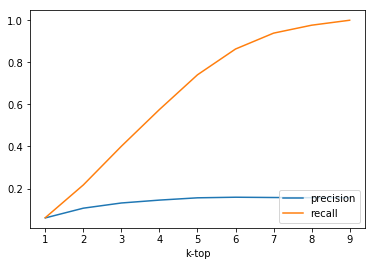

true: Inspecting pred: Inspecting


words,check,the,toilet,paper
lexical_unit,1.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.7257,0.2281,0.0461
slots_true,O,B-Ground,I-Ground,I-Ground
slots_pred,O,B-Theme,I-Theme,I-Theme


,check,the,toilet,paper
O,0.9940,0.0025,0.0023,0.0012
B-_,0.7897,0.1109,0.0749,0.0245
I-_,0.3002,0.3825,0.2064,0.1109
I-_,0.4173,0.3193,0.1714,0.0920


,O+check,B-_+the,I-_+toilet,I-_+paper
O,0.7660,0.0160,0.0442,0.1737
Theme,0.4090,0.0741,0.1876,0.3293
Theme,0.5896,0.0404,0.0673,0.3027
Theme,0.6213,0.0366,0.0648,0.2773


true: Bringing pred: Taking


words,can,you,please,take,out,the,garbage
lexical_unit,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.0001,0.1001,0.8997,0.0000
slots_true,O,B-Agent,O,O,B-Goal,B-Theme,I-Theme
slots_pred,O,B-Agent,O,O,B-Theme,I-Theme,I-Theme


,can,you,please,take,out,the,garbage
O,0.0006,0.0010,0.0111,0.1363,0.8411,0.0065,0.0034
B-_,0.0186,0.0481,0.4960,0.3207,0.1118,0.0030,0.0017
O,0.0013,0.0030,0.0174,0.1051,0.8700,0.0024,0.0008
O,0.0004,0.0010,0.0045,0.0371,0.9557,0.0010,0.0003
B-_,0.0014,0.0089,0.0089,0.0411,0.9387,0.0006,0.0004
I-_,0.0002,0.0004,0.0006,0.0025,0.8789,0.0555,0.0619
I-_,0.0002,0.0008,0.0014,0.0033,0.9314,0.0265,0.0365


,O+can,B-_+you,O+please,O+take,B-_+out,I-_+the,I-_+garbage
O,0.0311,0.0037,0.0279,0.0992,0.6739,0.0479,0.1163
Agent,0.0419,0.0142,0.0461,0.1039,0.4986,0.1478,0.1476
O,0.0396,0.0045,0.0304,0.0846,0.6422,0.0571,0.1415
O,0.0466,0.0062,0.0330,0.0932,0.6525,0.0498,0.1187
Theme,0.0648,0.0284,0.0588,0.1284,0.3914,0.1657,0.1624
Theme,0.0682,0.0244,0.0421,0.1250,0.4425,0.1359,0.1619
Theme,0.1863,0.0643,0.0987,0.1200,0.3248,0.0605,0.1455


true: Motion pred: Motion


words,go,next,to,the,tv,set
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0002,0.8204,0.1788,0.0003,0.0003
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,go,next,to,the,tv,set
O,0.1010,0.5842,0.2974,0.0055,0.0090,0.0029
B-_,0.0281,0.3953,0.5200,0.0243,0.0240,0.0083
I-_,0.0035,0.0597,0.8645,0.0622,0.0031,0.0069
I-_,0.0027,0.0309,0.8678,0.0874,0.0021,0.0091
I-_,0.0018,0.0325,0.8983,0.0616,0.0015,0.0043
I-_,0.0025,0.0347,0.8986,0.0530,0.0024,0.0087


,O+go,B-_+next,I-_+to,I-_+the,I-_+tv,I-_+set
O,0.2471,0.3297,0.2205,0.0301,0.0891,0.0836
Goal,0.2547,0.2932,0.1367,0.0388,0.1611,0.1155
Goal,0.2558,0.2510,0.1298,0.0521,0.1208,0.1905
Goal,0.2672,0.2404,0.1435,0.0500,0.0918,0.2070
Goal,0.2309,0.2526,0.1804,0.0519,0.0733,0.2110
Goal,0.2499,0.2733,0.1714,0.0474,0.0727,0.1852


true: Taking pred: Taking


words,grab,the,book,with,the,blue,cover
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0007,0.0032,0.0027,0.2783,0.2829,0.4304,0.0018
slots_true,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme
slots_pred,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme


,grab,the,book,with,the,blue,cover
O,0.3400,0.0076,0.2630,0.3663,0.0083,0.0117,0.0032
B-_,0.2512,0.0126,0.2484,0.4472,0.0105,0.0266,0.0034
I-_,0.1113,0.0357,0.2150,0.5294,0.0337,0.0682,0.0066
I-_,0.0762,0.0502,0.1486,0.5083,0.0828,0.0972,0.0366
I-_,0.0609,0.0785,0.1100,0.4017,0.1258,0.1270,0.0962
I-_,0.0636,0.0703,0.1014,0.4140,0.1258,0.1298,0.0950
I-_,0.0660,0.0694,0.1058,0.4261,0.1228,0.1280,0.0819


,O+grab,B-_+the,I-_+book,I-_+with,I-_+the,I-_+blue,I-_+cover
O,0.4521,0.0736,0.2066,0.1658,0.0416,0.0198,0.0405
Theme,0.2391,0.1126,0.1975,0.2051,0.0921,0.0672,0.0864
Theme,0.4045,0.1105,0.2006,0.1370,0.0516,0.0239,0.0719
Theme,0.4139,0.1099,0.2047,0.1407,0.0479,0.0217,0.0611
Theme,0.3805,0.1172,0.1991,0.1406,0.0561,0.0272,0.0792
Theme,0.3888,0.1250,0.2032,0.1336,0.0525,0.0235,0.0734
Theme,0.3892,0.1281,0.2021,0.1354,0.0531,0.0228,0.0694


true: Motion pred: Motion


words,move,to,the,left,of,the,table
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.9038,0.0353,0.0010,0.0092,0.0506,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,move,to,the,left,of,the,table
O,0.1673,0.3196,0.0182,0.4620,0.0285,0.0041,0.0003
B-_,0.0207,0.4896,0.0461,0.4043,0.0301,0.0083,0.0008
I-_,0.0036,0.5987,0.0710,0.2474,0.0713,0.0074,0.0007
I-_,0.0046,0.6299,0.0695,0.2359,0.0539,0.0054,0.0008
I-_,0.0049,0.5958,0.0814,0.2303,0.0762,0.0097,0.0016
I-_,0.0048,0.6034,0.0813,0.2159,0.0817,0.0109,0.0019
I-_,0.0055,0.5901,0.0852,0.2191,0.0855,0.0119,0.0027


,O+move,B-_+to,I-_+the,I-_+left,I-_+of,I-_+the,I-_+table
O,0.2708,0.1838,0.0781,0.1850,0.0618,0.0411,0.1793
Goal,0.3198,0.1602,0.0866,0.1624,0.0735,0.0641,0.1334
Goal,0.1662,0.1263,0.0637,0.1517,0.0496,0.0365,0.4059
Goal,0.1809,0.1710,0.0774,0.1928,0.0542,0.0360,0.2878
Goal,0.1665,0.1405,0.0701,0.1640,0.0540,0.0393,0.3656
Goal,0.1579,0.1541,0.0765,0.1850,0.0607,0.0397,0.3262
Goal,0.1604,0.1573,0.0766,0.1902,0.0604,0.0386,0.3165


true: Taking pred: Taking


words,take,the,magazine,that,is,in,the,bathroom
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0051,0.0549,0.0024,0.0047,0.0003,0.0003,0.9301,0.0000
slots_true,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme
slots_pred,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme


,take,the,magazine,that,is,in,the,bathroom
O,0.6408,0.0104,0.0800,0.0537,0.2003,0.0121,0.0022,0.0007
B-_,0.4461,0.0260,0.1902,0.0948,0.2358,0.0045,0.0016,0.0009
I-_,0.0760,0.0653,0.1839,0.1852,0.4854,0.0033,0.0007,0.0003
I-_,0.0271,0.0358,0.0410,0.0905,0.7966,0.0081,0.0007,0.0002
I-_,0.0285,0.0545,0.0482,0.1160,0.7407,0.0107,0.0011,0.0002
I-_,0.0153,0.0713,0.0308,0.0879,0.6533,0.1348,0.0035,0.0032
I-_,0.0181,0.0802,0.0283,0.0805,0.5633,0.2191,0.0058,0.0046
I-_,0.0189,0.0825,0.0306,0.0849,0.5891,0.1860,0.0047,0.0033


,O+take,B-_+the,I-_+magazine,I-_+that,I-_+is,I-_+in,I-_+the,I-_+bathroom
O,0.6123,0.1435,0.1259,0.0617,0.0313,0.0097,0.0082,0.0073
Theme,0.2628,0.1705,0.1572,0.1449,0.1081,0.0555,0.0461,0.0549
Theme,0.4312,0.1966,0.1712,0.0972,0.0607,0.0138,0.0077,0.0215
Theme,0.4561,0.2109,0.1771,0.0851,0.0390,0.0104,0.0058,0.0157
Theme,0.4420,0.2085,0.1846,0.0864,0.0401,0.0122,0.0068,0.0195
Theme,0.4546,0.2076,0.1716,0.0881,0.0408,0.0119,0.0067,0.0187
Theme,0.4378,0.2018,0.1782,0.0895,0.0437,0.0150,0.0086,0.0253
Theme,0.4372,0.2026,0.1795,0.0882,0.0431,0.0150,0.0085,0.0259


true: Motion pred: Motion


words,go,straight,to,the,living,room
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0003,0.0361,0.6663,0.2815,0.0158,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,go,straight,to,the,living,room
O,0.0823,0.8655,0.0479,0.0041,0.0003,0.0000
B-_,0.0301,0.6528,0.2988,0.0156,0.0025,0.0001
I-_,0.0037,0.2469,0.6673,0.0752,0.0065,0.0005
I-_,0.0035,0.2462,0.6639,0.0785,0.0073,0.0006
I-_,0.0035,0.2637,0.6599,0.0671,0.0053,0.0005
I-_,0.0045,0.2706,0.6562,0.0624,0.0058,0.0006


,O+go,B-_+straight,I-_+to,I-_+the,I-_+living,I-_+room
O,0.3819,0.2783,0.1276,0.0429,0.0482,0.1212
Goal,0.4511,0.2269,0.0847,0.0455,0.0684,0.1234
Goal,0.2317,0.1927,0.0998,0.0453,0.0744,0.3561
Goal,0.2257,0.2206,0.1158,0.0396,0.0602,0.3381
Goal,0.2250,0.2207,0.1395,0.0463,0.0571,0.3113
Goal,0.2335,0.2282,0.1380,0.0448,0.0549,0.3005


true: Searching pred: Searching


words,please,find,the,bed
lexical_unit,0.0000,1.0000,0.0000,0.0000
attention_intent,0.0000,0.0001,0.9987,0.0012
slots_true,O,O,B-Phenomenon,I-Phenomenon
slots_pred,O,O,B-Phenomenon,I-Phenomenon


,please,find,the,bed
O,0.0044,0.9945,0.0011,0.0000
O,0.0041,0.9949,0.0009,0.0001
B-_,0.0044,0.9856,0.0093,0.0007
I-_,0.0073,0.9547,0.0339,0.0041


,O+please,O+find,B-_+the,I-_+bed
O,0.4605,0.5023,0.0144,0.0228
O,0.4268,0.5239,0.0157,0.0337
Phenomenon,0.3220,0.4860,0.0774,0.1146
Phenomenon,0.5122,0.3986,0.0308,0.0584


true: Motion pred: Motion


words,go,to,living,room
lexical_unit,1.0000,0.0000,0.0000,0.0000
attention_intent,0.0005,0.7715,0.2279,0.0001
slots_true,O,B-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal


,go,to,living,room
O,0.8186,0.1779,0.0034,0.0001
B-_,0.1137,0.8736,0.0122,0.0005
I-_,0.0809,0.8980,0.0198,0.0012
I-_,0.0828,0.8882,0.0267,0.0023


,O+go,B-_+to,I-_+living,I-_+room
O,0.6409,0.1515,0.0616,0.1460
Goal,0.5868,0.1430,0.1039,0.1663
Goal,0.3479,0.1545,0.0714,0.4262
Goal,0.3827,0.1781,0.0684,0.3708


true: Bringing pred: Bringing


words,bring,me,a,fork,from,the,press
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0011,0.9507,0.0097,0.0031,0.0119,0.0233,0.0003
slots_true,O,B-Beneficiary,B-Theme,I-Theme,B-Source,I-Source,I-Source
slots_pred,O,B-Beneficiary,B-Theme,I-Theme,B-Source,I-Source,I-Source


,bring,me,a,fork,from,the,press
O,0.0128,0.7609,0.0148,0.1143,0.0927,0.0027,0.0018
B-_,0.0139,0.9579,0.0027,0.0229,0.0022,0.0002,0.0001
B-_,0.0735,0.8185,0.0368,0.0659,0.0042,0.0008,0.0002
I-_,0.0377,0.8586,0.0277,0.0714,0.0040,0.0005,0.0001
B-_,0.0003,0.0178,0.0178,0.0505,0.8831,0.0059,0.0245
I-_,0.0004,0.0163,0.0184,0.0369,0.9017,0.0038,0.0227
I-_,0.0003,0.0139,0.0145,0.0304,0.9121,0.0041,0.0247


,O+bring,B-_+me,B-_+a,I-_+fork,B-_+from,I-_+the,I-_+press
O,0.2817,0.3295,0.0417,0.2279,0.0653,0.0135,0.0405
Beneficiary,0.1394,0.3119,0.0880,0.2070,0.1468,0.0410,0.0660
Theme,0.1051,0.2684,0.0842,0.2128,0.2015,0.0424,0.0855
Theme,0.2478,0.3513,0.0527,0.1646,0.0870,0.0189,0.0776
Source,0.0941,0.3491,0.0604,0.2142,0.1987,0.0250,0.0585
Source,0.2237,0.3082,0.0795,0.1526,0.0964,0.0337,0.1059
Source,0.2631,0.3373,0.0710,0.1335,0.0812,0.0273,0.0866


true: Bringing pred: Bringing


words,i,would,like,some,loo,roll,can,you,get,me,some,loo,roll
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.9942,0.0002,0.0035,0.0019
slots_true,O,O,O,O,O,O,O,B-Agent,O,B-Beneficiary,B-Theme,I-Theme,I-Theme
slots_pred,O,O,O,O,O,O,O,B-Agent,O,B-Beneficiary,B-Theme,I-Theme,I-Theme


,i,would,like,some,loo,roll,can,you,get,me,some,loo,roll
O,0.0000,0.0001,0.0001,0.0001,0.0002,0.0005,0.0028,0.0044,0.0148,0.8846,0.0753,0.0127,0.0043
O,0.0001,0.0002,0.0004,0.0007,0.0025,0.0042,0.0112,0.0539,0.1591,0.7030,0.0507,0.0114,0.0026
O,0.0002,0.0003,0.0007,0.0012,0.0040,0.0066,0.0150,0.0627,0.2060,0.6449,0.0471,0.0096,0.0017
O,0.0003,0.0004,0.0009,0.0015,0.0047,0.0076,0.0179,0.0677,0.2081,0.6236,0.0539,0.0115,0.0019
O,0.0002,0.0003,0.0007,0.0013,0.0045,0.0074,0.0165,0.0594,0.1987,0.6420,0.0568,0.0104,0.0019
O,0.0002,0.0003,0.0007,0.0012,0.0041,0.0072,0.0166,0.0599,0.2015,0.6422,0.0544,0.0096,0.0020
O,0.0003,0.0004,0.0008,0.0014,0.0047,0.0078,0.0158,0.0621,0.2139,0.6337,0.0491,0.0081,0.0020
B-_,0.0005,0.0012,0.0020,0.0024,0.0065,0.0093,0.0096,0.1058,0.2480,0.5859,0.0227,0.0048,0.0013
O,0.0001,0.0002,0.0004,0.0007,0.0021,0.0046,0.0157,0.0381,0.0855,0.7687,0.0678,0.0141,0.0020
B-_,0.0002,0.0002,0.0003,0.0006,0.0017,0.0019,0.0037,0.0165,0.0176,0.8838,0.0660,0.0063,0.0012


,O+i,O+would,O+like,O+some,O+loo,O+roll,O+can,B-_+you,O+get,B-_+me,B-_+some,I-_+loo,I-_+roll
O,0.0091,0.0370,0.0418,0.0633,0.0410,0.0684,0.1582,0.0279,0.1606,0.1736,0.0493,0.0303,0.1395
O,0.0100,0.0387,0.0448,0.0657,0.0454,0.0693,0.1437,0.0351,0.1700,0.1654,0.0459,0.0324,0.1335
O,0.0094,0.0337,0.0387,0.0602,0.0412,0.0622,0.1631,0.0322,0.1599,0.1730,0.0466,0.0349,0.1450
O,0.0098,0.0373,0.0420,0.0618,0.0432,0.0666,0.1540,0.0359,0.1627,0.1649,0.0464,0.0337,0.1418
O,0.0093,0.0355,0.0396,0.0590,0.0422,0.0655,0.1496,0.0348,0.1692,0.1737,0.0462,0.0330,0.1424
O,0.0094,0.0326,0.0373,0.0570,0.0404,0.0593,0.1628,0.0321,0.1631,0.1826,0.0463,0.0347,0.1423
O,0.0097,0.0296,0.0358,0.0577,0.0383,0.0549,0.1685,0.0299,0.1543,0.1913,0.0504,0.0401,0.1393
Agent,0.0172,0.0287,0.0319,0.0510,0.0345,0.0446,0.1062,0.0357,0.1148,0.2114,0.1007,0.0724,0.1509
O,0.0114,0.0406,0.0462,0.0673,0.0490,0.0709,0.1345,0.0363,0.1606,0.1602,0.0561,0.0395,0.1275
Beneficiary,0.0207,0.0318,0.0344,0.0569,0.0445,0.0527,0.0953,0.0427,0.1088,0.1760,0.1122,0.0805,0.1435


true: Placing pred: Placing


words,can,you,put,the,detergent,in,the,washing,machine
lexical_unit,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.0263,0.0040,0.1772,0.4543,0.2213,0.1169
slots_true,O,B-Agent,O,B-Theme,I-Theme,B-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Agent,O,B-Theme,I-Theme,B-Goal,I-Goal,I-Goal,I-Goal


,can,you,put,the,detergent,in,the,washing,machine
O,0.0355,0.2147,0.3132,0.0224,0.1692,0.1319,0.0424,0.0413,0.0294
B-_,0.0677,0.7832,0.1220,0.0031,0.0120,0.0045,0.0025,0.0036,0.0015
O,0.0545,0.2302,0.2208,0.0228,0.3301,0.0684,0.0281,0.0335,0.0116
B-_,0.0509,0.2314,0.4723,0.0150,0.2162,0.0052,0.0025,0.0047,0.0018
I-_,0.0159,0.0533,0.0963,0.1528,0.5199,0.0887,0.0239,0.0363,0.0128
B-_,0.0020,0.0030,0.0020,0.0038,0.0096,0.2780,0.1225,0.0276,0.5516
I-_,0.0046,0.0054,0.0023,0.0037,0.0077,0.3166,0.1215,0.0202,0.5179
I-_,0.0066,0.0085,0.0033,0.0043,0.0092,0.3678,0.1377,0.0206,0.4422
I-_,0.0080,0.0110,0.0036,0.0044,0.0093,0.4061,0.1439,0.0207,0.3931


,O+can,B-_+you,O+put,B-_+the,I-_+detergent,B-_+in,I-_+the,I-_+washing,I-_+machine
O,0.0659,0.0186,0.1635,0.0215,0.1185,0.1092,0.0784,0.0813,0.3430
Agent,0.0657,0.0373,0.1263,0.0567,0.1286,0.1194,0.1010,0.1301,0.2350
O,0.0861,0.0246,0.1459,0.0195,0.1159,0.1034,0.0750,0.0705,0.3590
Theme,0.0877,0.0518,0.1385,0.0701,0.1248,0.1131,0.1041,0.1194,0.1906
Theme,0.2008,0.0643,0.1177,0.0223,0.0687,0.0821,0.0632,0.0541,0.3269
Goal,0.0625,0.0285,0.0989,0.0580,0.1333,0.1411,0.1285,0.1273,0.2220
Goal,0.1938,0.0976,0.1393,0.0348,0.0794,0.0943,0.0755,0.0529,0.2323
Goal,0.2275,0.0834,0.1429,0.0284,0.0631,0.0719,0.0660,0.0507,0.2660
Goal,0.2289,0.0967,0.1497,0.0320,0.0605,0.0692,0.0644,0.0509,0.2479


In [3]:
samples = load_json(FOLDER_3_BI_RNN)
print('lexical_unit score:', align_accuracy_argmax(samples))
align_score(samples)
display_all(samples, True, True, False, 10)

lexical_unit score: 0.8148148148148148
(694,)


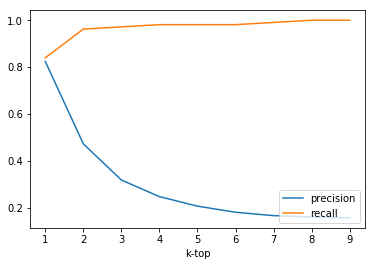

true: Inspecting pred: Inspecting


words,check,the,toilet,paper
lexical_unit,1.0000,0.0000,0.0000,0.0000
attention_intent,1.0000,0.0000,0.0000,0.0000
slots_true,O,B-Ground,I-Ground,I-Ground
slots_pred,O,B-Phenomenon,I-Phenomenon,I-Phenomenon


,check,the,toilet,paper
O,0.9755,0.0062,0.0172,0.0012
B-Phenomenon,0.8034,0.0598,0.1279,0.0088
I-Phenomenon,0.1829,0.1302,0.2459,0.4410
I-Phenomenon,0.1649,0.1285,0.1862,0.5204


true: Bringing pred: Taking


words,can,you,please,take,out,the,garbage
lexical_unit,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
attention_intent,0.0006,0.0002,0.0002,0.0545,0.9387,0.0000,0.0058
slots_true,O,B-Agent,O,O,B-Goal,B-Theme,I-Theme
slots_pred,O,B-Theme,O,O,B-Theme,I-Theme,I-Theme


,can,you,please,take,out,the,garbage
O,0.0054,0.0020,0.0184,0.1006,0.8084,0.0203,0.0449
B-Theme,0.0070,0.0108,0.3836,0.5492,0.0400,0.0051,0.0044
O,0.0002,0.0003,0.0004,0.0057,0.6810,0.0375,0.2749
O,0.0027,0.0017,0.0126,0.0844,0.6674,0.0282,0.2030
B-Theme,0.0018,0.0007,0.0003,0.0065,0.9799,0.0082,0.0026
I-Theme,0.0005,0.0003,0.0001,0.0008,0.2163,0.2683,0.5138
I-Theme,0.0001,0.0001,0.0000,0.0002,0.0885,0.1688,0.7424


true: Motion pred: Motion


words,go,next,to,the,tv,set
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.4336,0.0002,0.0252,0.0000,0.0000,0.5410
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,go,next,to,the,tv,set
O,0.1107,0.2730,0.5639,0.0148,0.0281,0.0097
B-Goal,0.1638,0.5307,0.2540,0.0094,0.0401,0.0019
I-Goal,0.0002,0.0054,0.4751,0.0609,0.0141,0.4443
I-Goal,0.0001,0.0025,0.3695,0.0315,0.0080,0.5884
I-Goal,0.0005,0.0097,0.4519,0.0754,0.0227,0.4397
I-Goal,0.0003,0.0052,0.3847,0.0418,0.0120,0.5560


true: Taking pred: Taking


words,grab,the,book,with,the,blue,cover
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
slots_true,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme
slots_pred,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme


,grab,the,book,with,the,blue,cover
O,0.6383,0.0250,0.2211,0.1133,0.0010,0.0006,0.0007
B-Theme,0.0558,0.1607,0.3596,0.3704,0.0202,0.0190,0.0142
I-Theme,0.0313,0.1095,0.2299,0.3499,0.0707,0.0654,0.1433
I-Theme,0.0044,0.0350,0.1002,0.4121,0.0629,0.0630,0.3223
I-Theme,0.0078,0.0556,0.1661,0.4005,0.0807,0.0768,0.2126
I-Theme,0.0086,0.0613,0.1618,0.4124,0.0793,0.0776,0.1991
I-Theme,0.0025,0.0225,0.0611,0.3834,0.0616,0.0588,0.4101


true: Motion pred: Motion


words,move,to,the,left,of,the,table
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.9605,0.0395,0.0000,0.0000,0.0000,0.0000,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,move,to,the,left,of,the,table
O,0.0358,0.4999,0.0412,0.4074,0.0121,0.0009,0.0028
B-Goal,0.0063,0.2080,0.1120,0.6180,0.0437,0.0057,0.0063
I-Goal,0.0003,0.0479,0.0625,0.4794,0.2175,0.0416,0.1508
I-Goal,0.0003,0.0491,0.0651,0.4874,0.1997,0.0353,0.1631
I-Goal,0.0004,0.0492,0.0663,0.4514,0.2012,0.0378,0.1936
I-Goal,0.0007,0.0712,0.0927,0.4589,0.1837,0.0384,0.1545
I-Goal,0.0007,0.0670,0.0878,0.4679,0.1808,0.0369,0.1590


true: Taking pred: Taking


words,take,the,magazine,that,is,in,the,bathroom
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.9565,0.0000,0.0000,0.0025,0.0407,0.0000,0.0000,0.0000
slots_true,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme
slots_pred,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme


,take,the,magazine,that,is,in,the,bathroom
O,0.7388,0.0851,0.0595,0.0407,0.0749,0.0008,0.0000,0.0002
B-Theme,0.0319,0.2938,0.2564,0.2317,0.1792,0.0052,0.0003,0.0015
I-Theme,0.0117,0.1910,0.1508,0.2641,0.3045,0.0414,0.0054,0.0311
I-Theme,0.0013,0.0495,0.0647,0.3138,0.5134,0.0301,0.0018,0.0254
I-Theme,0.0005,0.0129,0.0193,0.1997,0.7421,0.0132,0.0007,0.0116
I-Theme,0.0004,0.0063,0.0085,0.1289,0.8279,0.0152,0.0011,0.0115
I-Theme,0.0002,0.0059,0.0100,0.1470,0.8072,0.0150,0.0006,0.0140
I-Theme,0.0002,0.0048,0.0073,0.1332,0.8200,0.0176,0.0012,0.0157


true: Motion pred: Closure


words,go,straight,to,the,living,room
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.1154,0.8779,0.0067,0.0000,0.0000,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,go,straight,to,the,living,room
O,0.0664,0.7946,0.1318,0.0035,0.0017,0.0019
B-Goal,0.0376,0.6768,0.2501,0.0157,0.0131,0.0067
I-Goal,0.0003,0.0491,0.5397,0.1728,0.0430,0.1951
I-Goal,0.0003,0.0349,0.5169,0.1559,0.0351,0.2569
I-Goal,0.0002,0.0418,0.4795,0.1684,0.0419,0.2681
I-Goal,0.0003,0.0450,0.4688,0.1641,0.0397,0.2820


true: Searching pred: Searching


words,please,find,the,bed
lexical_unit,0.0000,1.0000,0.0000,0.0000
attention_intent,0.0000,1.0000,0.0000,0.0000
slots_true,O,O,B-Phenomenon,I-Phenomenon
slots_pred,O,O,B-Phenomenon,I-Phenomenon


,please,find,the,bed
O,0.0025,0.9936,0.0009,0.0029
O,0.0040,0.9913,0.0018,0.0029
B-Phenomenon,0.0012,0.9355,0.0480,0.0153
I-Phenomenon,0.0004,0.3296,0.1504,0.5196


true: Motion pred: Motion


words,go,to,living,room
lexical_unit,1.0000,0.0000,0.0000,0.0000
attention_intent,0.9450,0.0550,0.0000,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal


,go,to,living,room
O,0.2284,0.6838,0.0477,0.0402
B-Goal,0.0336,0.6310,0.1122,0.2232
I-Goal,0.0029,0.3287,0.1057,0.5627
I-Goal,0.0019,0.3063,0.0821,0.6097


true: Bringing pred: Bringing


words,bring,me,a,fork,from,the,press
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
slots_true,O,B-Beneficiary,B-Theme,I-Theme,B-Source,I-Source,I-Source
slots_pred,O,B-Beneficiary,B-Theme,I-Theme,B-Source,I-Source,I-Source


,bring,me,a,fork,from,the,press
O,0.0089,0.4480,0.0525,0.0679,0.4217,0.0006,0.0004
B-Beneficiary,0.0019,0.9976,0.0003,0.0001,0.0002,0.0000,0.0000
B-Theme,0.0000,0.0026,0.0737,0.1915,0.6736,0.0198,0.0388
I-Theme,0.0001,0.0356,0.1540,0.2328,0.4275,0.0626,0.0873
B-Source,0.0000,0.0001,0.0006,0.0056,0.9918,0.0006,0.0012
I-Source,0.0000,0.0001,0.0003,0.0046,0.9943,0.0002,0.0005
I-Source,0.0000,0.0000,0.0003,0.0097,0.9890,0.0002,0.0008


true: Bringing pred: Bringing


words,i,would,like,some,loo,roll,can,you,get,me,some,loo,roll
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.7424,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.2574,0.0000,0.0000,0.0000,0.0000
slots_true,O,O,O,O,O,O,O,B-Agent,O,B-Beneficiary,B-Theme,I-Theme,I-Theme
slots_pred,O,O,O,O,O,O,O,B-Agent,O,B-Beneficiary,B-Theme,I-Theme,I-Theme


,i,would,like,some,loo,roll,can,you,get,me,some,loo,roll
O,0.0005,0.0008,0.0006,0.0004,0.0031,0.0053,0.0178,0.0189,0.0365,0.3797,0.3492,0.1058,0.0815
O,0.0015,0.0013,0.0012,0.0009,0.0043,0.0093,0.0440,0.0421,0.0617,0.3415,0.2661,0.1130,0.1131
O,0.0018,0.0017,0.0015,0.0011,0.0055,0.0109,0.0483,0.0494,0.0668,0.4256,0.2105,0.0928,0.0840
O,0.0010,0.0010,0.0010,0.0006,0.0032,0.0059,0.0224,0.0204,0.0257,0.4291,0.2990,0.1113,0.0794
O,0.0011,0.0012,0.0011,0.0007,0.0038,0.0072,0.0234,0.0253,0.0344,0.4313,0.2856,0.1200,0.0649
O,0.0028,0.0036,0.0031,0.0021,0.0104,0.0173,0.0562,0.0761,0.1200,0.4203,0.1681,0.0811,0.0389
O,0.0013,0.0015,0.0014,0.0010,0.0051,0.0094,0.0257,0.0253,0.0430,0.3928,0.3105,0.1160,0.0670
B-Agent,0.0031,0.0057,0.0045,0.0034,0.0117,0.0142,0.0474,0.5196,0.3223,0.0371,0.0157,0.0074,0.0078
O,0.0001,0.0002,0.0003,0.0003,0.0002,0.0003,0.0005,0.0003,0.0010,0.1395,0.6495,0.1039,0.1040
B-Beneficiary,0.0006,0.0005,0.0008,0.0006,0.0021,0.0043,0.0100,0.0038,0.0146,0.9184,0.0276,0.0155,0.0011


true: Placing pred: Placing


words,can,you,put,the,detergent,in,the,washing,machine
lexical_unit,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
slots_true,O,B-Agent,O,B-Theme,I-Theme,B-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Agent,O,B-Theme,I-Theme,B-Goal,I-Goal,I-Goal,I-Goal


,can,you,put,the,detergent,in,the,washing,machine
O,0.0304,0.0850,0.1555,0.0109,0.4634,0.0469,0.0213,0.1661,0.0206
B-Agent,0.1673,0.8047,0.0199,0.0011,0.0041,0.0007,0.0006,0.0012,0.0005
O,0.0009,0.0045,0.0464,0.0280,0.3491,0.0906,0.0406,0.2598,0.1801
B-Theme,0.0033,0.0037,0.2400,0.2262,0.3089,0.0615,0.0401,0.1034,0.0128
I-Theme,0.0014,0.0016,0.0824,0.1671,0.2957,0.1160,0.1155,0.1505,0.0699
B-Goal,0.0001,0.0001,0.0004,0.0016,0.0107,0.0766,0.0423,0.0618,0.8066
I-Goal,0.0001,0.0001,0.0003,0.0010,0.0037,0.0217,0.0129,0.0233,0.9369
I-Goal,0.0000,0.0000,0.0001,0.0006,0.0028,0.0225,0.0128,0.0208,0.9405
I-Goal,0.0000,0.0000,0.0001,0.0008,0.0043,0.0379,0.0210,0.0340,0.9018


In [4]:
samples = load_json(FOLDER_2_WEIGHTED_EMB)
print('lexical_unit score:', align_accuracy_argmax(samples))
align_score(samples)
display_all(samples, False, False, True, 10)

lexical_unit score: 0.05555555555555555
(694,)


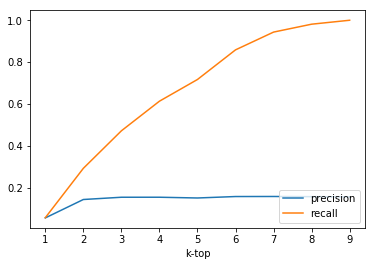

true: Inspecting pred: Inspecting


words,check,the,toilet,paper
lexical_unit,1.0000,0.0000,0.0000,0.0000
attention_intent,0.0002,0.9318,0.0517,0.0162
slots_true,O,B-Ground,I-Ground,I-Ground
slots_pred,O,B-Phenomenon,I-Phenomenon,I-Containing_object


,check,the,toilet,paper
O,0.9959,0.0018,0.0017,0.0007
B-Phenomenon,0.9107,0.0280,0.0359,0.0255
I-Phenomenon,0.6533,0.1030,0.1203,0.1234
I-Containing_object,0.3390,0.1913,0.1409,0.3288


true: Bringing pred: Taking


words,can,you,please,take,out,the,garbage
lexical_unit,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.0000,0.2952,0.7045,0.0001
slots_true,O,B-Agent,O,O,B-Goal,B-Theme,I-Theme
slots_pred,O,B-Agent,O,O,B-Theme,B-Theme,I-Theme


,can,you,please,take,out,the,garbage
O,0.0005,0.0004,0.0027,0.1215,0.8464,0.0229,0.0055
B-Agent,0.0012,0.0009,0.0093,0.2605,0.7068,0.0169,0.0043
O,0.0012,0.0008,0.0032,0.0938,0.8698,0.0238,0.0074
O,0.0002,0.0002,0.0012,0.0493,0.9346,0.0122,0.0022
B-Theme,0.0000,0.0000,0.0001,0.0046,0.9890,0.0053,0.0010
B-Theme,0.0003,0.0002,0.0004,0.0083,0.7373,0.1973,0.0561
I-Theme,0.0004,0.0003,0.0005,0.0041,0.4895,0.2889,0.2163


true: Motion pred: Motion


words,go,next,to,the,tv,set
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0098,0.9410,0.0393,0.0098,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,go,next,to,the,tv,set
O,0.0794,0.2384,0.5801,0.0118,0.0633,0.0269
B-Goal,0.0969,0.3479,0.5110,0.0110,0.0290,0.0042
I-Goal,0.0028,0.0347,0.7722,0.0365,0.0372,0.1166
I-Goal,0.0065,0.0476,0.6936,0.0387,0.0419,0.1718
I-Goal,0.0165,0.0833,0.6286,0.0451,0.0678,0.1586
I-Goal,0.0163,0.0708,0.5715,0.0486,0.0684,0.2243


true: Taking pred: Taking


words,grab,the,book,with,the,blue,cover
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0005,0.0322,0.0118,0.1519,0.7089,0.0943,0.0000
slots_true,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme
slots_pred,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme


,grab,the,book,with,the,blue,cover
O,0.7958,0.0187,0.1091,0.0660,0.0039,0.0049,0.0014
B-Theme,0.4885,0.0895,0.2416,0.1282,0.0194,0.0225,0.0103
I-Theme,0.2223,0.1480,0.2080,0.1794,0.0660,0.0947,0.0816
I-Theme,0.0264,0.0638,0.1466,0.3496,0.1585,0.1711,0.0840
I-Theme,0.0306,0.0568,0.1344,0.3125,0.1677,0.1730,0.1249
I-Theme,0.0345,0.0617,0.1413,0.3206,0.1588,0.1685,0.1147
I-Theme,0.0251,0.0587,0.1185,0.2942,0.1865,0.1976,0.1194


true: Motion pred: Motion


words,move,to,the,left,of,the,table
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0008,0.4367,0.0763,0.2766,0.1804,0.0292,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,move,to,the,left,of,the,table
O,0.1396,0.4747,0.0365,0.3301,0.0167,0.0022,0.0001
B-Goal,0.0779,0.4915,0.0627,0.3384,0.0269,0.0026,0.0001
I-Goal,0.0090,0.6164,0.0565,0.2239,0.0635,0.0187,0.0120
I-Goal,0.0198,0.5286,0.0797,0.2806,0.0664,0.0156,0.0093
I-Goal,0.0262,0.5318,0.0839,0.2821,0.0592,0.0125,0.0043
I-Goal,0.0313,0.5321,0.0847,0.2834,0.0546,0.0109,0.0030
I-Goal,0.0367,0.5314,0.0844,0.2813,0.0526,0.0108,0.0028


true: Taking pred: Taking


words,take,the,magazine,that,is,in,the,bathroom
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0015,0.9541,0.0281,0.0002,0.0000,0.0008,0.0124,0.0000
slots_true,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme
slots_pred,O,B-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme,I-Theme


,take,the,magazine,that,is,in,the,bathroom
O,0.9567,0.0146,0.0133,0.0039,0.0083,0.0021,0.0007,0.0004
B-Theme,0.7559,0.0834,0.0819,0.0270,0.0276,0.0128,0.0086,0.0029
I-Theme,0.3250,0.1616,0.2445,0.0961,0.1176,0.0324,0.0148,0.0081
I-Theme,0.0551,0.1606,0.2828,0.1242,0.1969,0.1305,0.0408,0.0090
I-Theme,0.0404,0.1513,0.2629,0.1338,0.2142,0.1551,0.0362,0.0059
I-Theme,0.0500,0.1492,0.2113,0.1746,0.2469,0.1395,0.0248,0.0037
I-Theme,0.0476,0.1278,0.1648,0.1657,0.2738,0.1788,0.0369,0.0046
I-Theme,0.0464,0.1400,0.1820,0.1624,0.2675,0.1663,0.0314,0.0039


true: Motion pred: Motion


words,go,straight,to,the,living,room
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0003,0.0997,0.7372,0.1600,0.0028,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal,I-Goal,I-Goal


,go,straight,to,the,living,room
O,0.0531,0.8055,0.1370,0.0031,0.0012,0.0001
B-Goal,0.1560,0.7442,0.0961,0.0027,0.0010,0.0000
I-Goal,0.0021,0.1715,0.7896,0.0289,0.0064,0.0015
I-Goal,0.0061,0.1881,0.7504,0.0376,0.0125,0.0052
I-Goal,0.0094,0.2534,0.7030,0.0246,0.0079,0.0017
I-Goal,0.0126,0.2940,0.6572,0.0246,0.0093,0.0023


true: Searching pred: Searching


words,please,find,the,bed
lexical_unit,0.0000,1.0000,0.0000,0.0000
attention_intent,0.0000,0.0033,0.9962,0.0005
slots_true,O,O,B-Phenomenon,I-Phenomenon
slots_pred,O,O,B-Phenomenon,I-Phenomenon


,please,find,the,bed
O,0.0079,0.9797,0.0112,0.0012
O,0.0026,0.9914,0.0055,0.0005
B-Phenomenon,0.0019,0.9540,0.0390,0.0051
I-Phenomenon,0.0016,0.4793,0.3625,0.1566


true: Motion pred: Motion


words,go,to,living,room
lexical_unit,1.0000,0.0000,0.0000,0.0000
attention_intent,0.0039,0.9382,0.0579,0.0000
slots_true,O,B-Goal,I-Goal,I-Goal
slots_pred,O,B-Goal,I-Goal,I-Goal


,go,to,living,room
O,0.7248,0.2495,0.0249,0.0008
B-Goal,0.5151,0.4716,0.0130,0.0003
I-Goal,0.0695,0.8567,0.0451,0.0287
I-Goal,0.1071,0.7645,0.0776,0.0508


true: Bringing pred: Bringing


words,bring,me,a,fork,from,the,press
lexical_unit,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.1346,0.8637,0.0001,0.0000,0.0012,0.0003,0.0000
slots_true,O,B-Beneficiary,B-Theme,I-Theme,B-Source,I-Source,I-Source
slots_pred,O,B-Beneficiary,B-Theme,I-Theme,B-Source,I-Source,I-Source


,bring,me,a,fork,from,the,press
O,0.0048,0.6505,0.0402,0.1254,0.1634,0.0087,0.0070
B-Beneficiary,0.0044,0.9242,0.0126,0.0340,0.0205,0.0027,0.0015
B-Theme,0.0015,0.0345,0.1337,0.1201,0.6548,0.0379,0.0174
I-Theme,0.0078,0.2899,0.2290,0.2130,0.1846,0.0440,0.0316
B-Source,0.0001,0.0011,0.0069,0.0168,0.9368,0.0079,0.0303
I-Source,0.0001,0.0012,0.0068,0.0248,0.9314,0.0069,0.0288
I-Source,0.0000,0.0009,0.0053,0.0290,0.9416,0.0045,0.0186


true: Bringing pred: Bringing


words,i,would,like,some,loo,roll,can,you,get,me,some,loo,roll
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0005,0.9939,0.0045,0.0008,0.0001
slots_true,O,O,O,O,O,O,O,B-Agent,O,B-Beneficiary,B-Theme,I-Theme,I-Theme
slots_pred,O,O,O,O,O,O,O,B-Agent,O,B-Beneficiary,B-Theme,I-Theme,I-Theme


,i,would,like,some,loo,roll,can,you,get,me,some,loo,roll
O,0.0001,0.0000,0.0001,0.0002,0.0019,0.0116,0.0107,0.0053,0.0771,0.4376,0.2541,0.1121,0.0892
O,0.0002,0.0001,0.0002,0.0005,0.0032,0.0160,0.0137,0.0055,0.0776,0.3113,0.2275,0.1022,0.2420
O,0.0006,0.0001,0.0003,0.0010,0.0096,0.0362,0.0273,0.0183,0.1667,0.5038,0.1229,0.0517,0.0615
O,0.0005,0.0001,0.0002,0.0009,0.0078,0.0312,0.0244,0.0148,0.1508,0.4853,0.1483,0.0580,0.0778
O,0.0004,0.0001,0.0002,0.0006,0.0059,0.0273,0.0223,0.0126,0.1486,0.5007,0.1532,0.0560,0.0720
O,0.0002,0.0001,0.0001,0.0003,0.0030,0.0191,0.0183,0.0096,0.1444,0.5571,0.1387,0.0462,0.0629
O,0.0002,0.0000,0.0001,0.0002,0.0022,0.0174,0.0159,0.0088,0.1445,0.6160,0.1088,0.0375,0.0483
B-Agent,0.0003,0.0001,0.0001,0.0004,0.0028,0.0232,0.0263,0.0195,0.2038,0.6235,0.0606,0.0220,0.0174
O,0.0003,0.0001,0.0002,0.0005,0.0045,0.0225,0.0189,0.0094,0.1219,0.4665,0.1859,0.0706,0.0988
B-Beneficiary,0.0000,0.0000,0.0000,0.0000,0.0001,0.0010,0.0016,0.0007,0.0350,0.8577,0.0824,0.0089,0.0125


true: Placing pred: Placing


words,can,you,put,the,detergent,in,the,washing,machine
lexical_unit,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0003,0.0041,0.0015,0.3084,0.4410,0.2375,0.0071
slots_true,O,B-Agent,O,B-Theme,I-Theme,B-Goal,I-Goal,I-Goal,I-Goal
slots_pred,O,B-Agent,O,B-Theme,I-Theme,B-Goal,I-Goal,I-Goal,I-Goal


,can,you,put,the,detergent,in,the,washing,machine
O,0.0086,0.0883,0.7418,0.0051,0.1217,0.0118,0.0068,0.0138,0.0022
B-Agent,0.0267,0.4391,0.4833,0.0042,0.0287,0.0051,0.0041,0.0075,0.0012
O,0.0111,0.0844,0.5614,0.0104,0.2205,0.0474,0.0219,0.0403,0.0026
B-Theme,0.0034,0.0089,0.3393,0.0722,0.3039,0.0836,0.0694,0.1084,0.0109
I-Theme,0.0098,0.0225,0.2323,0.1432,0.2804,0.0828,0.0879,0.1034,0.0376
B-Goal,0.0004,0.0009,0.0051,0.0115,0.0450,0.3725,0.2579,0.1811,0.1255
I-Goal,0.0004,0.0006,0.0015,0.0023,0.0086,0.5438,0.2256,0.0875,0.1297
I-Goal,0.0005,0.0008,0.0015,0.0024,0.0097,0.5933,0.2149,0.0833,0.0936
I-Goal,0.0005,0.0010,0.0020,0.0037,0.0185,0.5479,0.2314,0.1143,0.0808


In [5]:
samples = load_json(FOLDER_2_BI_RNN)
print('lexical_unit score:', align_accuracy_argmax(samples))
align_score(samples)
display_all(samples, False, False, True, 10)

In [6]:
samples=load_json(FOLDER_3_ATIS, 9)
#align_score(samples)
display_all(samples, True, True, False, 10)

true: atis_flight pred: atis_flight


words,show,me,the,round,trip,flights,between,phoenix,and,salt,lake,city
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.0000,0.0000,0.4718,0.0067,0.3910,0.0125,0.0070,0.0178,0.0931
slots_true,O,O,O,B-round_trip,I-round_trip,O,O,B-fromloc.city_name,O,B-toloc.city_name,I-toloc.city_name,I-toloc.city_name
slots_pred,O,O,O,B-round_trip,I-round_trip,O,O,B-fromloc.city_name,O,B-toloc.city_name,I-toloc.city_name,I-toloc.city_name


,show,me,the,round,trip,flights,between,phoenix,and,salt,lake,city
O,0.2501,0.2263,0.3282,0.0470,0.0855,0.0139,0.0469,0.0005,0.0009,0.0002,0.0002,0.0003
O,0.2234,0.2302,0.3347,0.0633,0.0863,0.0157,0.0425,0.0011,0.0010,0.0004,0.0004,0.0009
O,0.1883,0.2229,0.4464,0.0471,0.0460,0.0105,0.0334,0.0015,0.0013,0.0008,0.0007,0.0011
B-_,0.0005,0.0005,0.0007,0.2582,0.7041,0.0269,0.0034,0.0013,0.0002,0.0007,0.0007,0.0028
I-_,0.0003,0.0004,0.0004,0.1475,0.8060,0.0293,0.0035,0.0031,0.0003,0.0011,0.0020,0.0061
O,0.1657,0.1360,0.1367,0.0822,0.2071,0.0578,0.1939,0.0044,0.0049,0.0026,0.0021,0.0067
O,0.1051,0.1142,0.1362,0.0624,0.1614,0.1159,0.2770,0.0038,0.0161,0.0023,0.0018,0.0039
B-_,0.0001,0.0002,0.0003,0.0109,0.0318,0.0055,0.0037,0.0669,0.0017,0.0564,0.0745,0.7478
O,0.0466,0.0691,0.0558,0.1203,0.2737,0.1571,0.1694,0.0134,0.0446,0.0107,0.0082,0.0311
B-_,0.0000,0.0000,0.0001,0.0016,0.0037,0.0005,0.0004,0.0188,0.0004,0.0280,0.0441,0.9024


,O+show,O+me,O+the,B-_+round,I-_+trip,O+flights,O+between,B-_+phoenix,O+and,B-_+salt,I-_+lake,I-_+city
O,0.0387,0.0326,0.4045,0.3133,0.0331,0.0047,0.0250,0.0038,0.0331,0.0302,0.0257,0.0552
O,0.0388,0.0302,0.4101,0.3197,0.0342,0.0060,0.0251,0.0045,0.0261,0.0262,0.0244,0.0548
O,0.0387,0.0291,0.4169,0.3199,0.0339,0.0060,0.0257,0.0043,0.0252,0.0251,0.0227,0.0526
round_trip,0.0152,0.0149,0.0662,0.1630,0.0500,0.0096,0.0356,0.0077,0.0389,0.0716,0.0845,0.4428
round_trip,0.0172,0.0163,0.0842,0.2095,0.0642,0.0072,0.0245,0.0065,0.0305,0.0669,0.0919,0.3810
O,0.0373,0.0257,0.3545,0.3369,0.0356,0.0057,0.0295,0.0042,0.0265,0.0293,0.0289,0.0859
O,0.0551,0.0456,0.3983,0.3067,0.0458,0.0048,0.0240,0.0037,0.0293,0.0242,0.0224,0.0402
fromloc.city_name,0.0166,0.0159,0.1049,0.1998,0.0569,0.0139,0.0526,0.0098,0.0541,0.0832,0.0781,0.3142
O,0.0470,0.0330,0.3754,0.3161,0.0389,0.0066,0.0315,0.0044,0.0296,0.0268,0.0251,0.0655
toloc.city_name,0.0152,0.0149,0.0684,0.1667,0.0536,0.0116,0.0378,0.0090,0.0397,0.0756,0.0909,0.4166


true: atis_flight pred: atis_flight


words,what,first,class,flights,are,available,on,july,twenty,fifth,1991,from,denver,to,baltimore
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.2631,0.0012,0.0048,0.0027,0.0020,0.0002,0.0000,0.0029,0.0046,0.6897,0.0095,0.0188
slots_true,O,B-class_type,I-class_type,O,O,O,O,B-depart_date.month_name,B-depart_date.day_number,I-depart_date.day_number,B-depart_date.year,O,B-fromloc.city_name,O,B-toloc.city_name
slots_pred,O,B-class_type,I-class_type,O,O,O,O,B-depart_date.month_name,B-depart_date.day_number,I-depart_date.day_number,B-depart_date.year,O,B-fromloc.city_name,O,B-toloc.city_name


,what,first,class,flights,are,available,on,july,twenty,fifth,1991,from,denver,to,baltimore
O,0.7729,0.0800,0.0915,0.0136,0.0074,0.0094,0.0081,0.0012,0.0013,0.0025,0.0097,0.0017,0.0004,0.0001,0.0004
B-_,0.0019,0.2160,0.6092,0.0216,0.0038,0.0057,0.0051,0.0146,0.0313,0.0202,0.0642,0.0022,0.0010,0.0010,0.0021
I-_,0.0005,0.0945,0.8514,0.0133,0.0013,0.0013,0.0007,0.0034,0.0046,0.0043,0.0230,0.0004,0.0007,0.0002,0.0005
O,0.6402,0.0822,0.1049,0.0318,0.0283,0.0286,0.0387,0.0019,0.0046,0.0068,0.0208,0.0090,0.0007,0.0006,0.0008
O,0.2453,0.0828,0.1000,0.0869,0.0706,0.0838,0.1519,0.0099,0.0203,0.0260,0.0597,0.0549,0.0022,0.0036,0.0021
O,0.3355,0.0755,0.1074,0.0543,0.0651,0.0851,0.1280,0.0070,0.0156,0.0191,0.0502,0.0512,0.0018,0.0020,0.0022
O,0.2497,0.0725,0.0904,0.0825,0.0804,0.0913,0.1511,0.0070,0.0193,0.0239,0.0486,0.0760,0.0018,0.0041,0.0015
B-_,0.0001,0.0081,0.0068,0.0024,0.0007,0.0010,0.0010,0.3301,0.2578,0.2290,0.1375,0.0005,0.0071,0.0011,0.0169
B-_,0.0004,0.0295,0.0536,0.0038,0.0046,0.0032,0.0020,0.0437,0.2239,0.1969,0.4257,0.0026,0.0053,0.0007,0.0041
I-_,0.0003,0.0251,0.0670,0.0035,0.0044,0.0038,0.0016,0.0317,0.2044,0.1567,0.4858,0.0016,0.0054,0.0010,0.0077


,O+what,B-_+first,I-_+class,O+flights,O+are,O+available,O+on,B-_+july,B-_+twenty,I-_+fifth,B-_+1991,O+from,B-_+denver,O+to,B-_+baltimore
O,0.2144,0.3151,0.0415,0.0067,0.0119,0.0107,0.0193,0.0220,0.0522,0.0632,0.0320,0.1159,0.0073,0.0272,0.0606
class_type,0.0754,0.1755,0.0259,0.0076,0.0187,0.0138,0.0168,0.0387,0.1306,0.1258,0.0628,0.0785,0.0069,0.0355,0.1875
class_type,0.0464,0.2037,0.0374,0.0056,0.0197,0.0121,0.0110,0.0419,0.1375,0.1512,0.0719,0.0378,0.0055,0.0258,0.1925
O,0.2181,0.3822,0.0403,0.0059,0.0121,0.0091,0.0126,0.0164,0.0509,0.0784,0.0404,0.0599,0.0043,0.0156,0.0540
O,0.2245,0.3578,0.0558,0.0059,0.0126,0.0104,0.0170,0.0168,0.0487,0.0871,0.0412,0.0639,0.0051,0.0166,0.0365
O,0.2289,0.3548,0.0481,0.0066,0.0131,0.0109,0.0163,0.0184,0.0463,0.0768,0.0378,0.0719,0.0054,0.0173,0.0473
O,0.2289,0.3459,0.0443,0.0070,0.0131,0.0110,0.0165,0.0204,0.0492,0.0774,0.0393,0.0728,0.0057,0.0173,0.0512
depart_date.month_name,0.0781,0.1749,0.0263,0.0090,0.0209,0.0156,0.0195,0.0450,0.1336,0.1167,0.0641,0.0912,0.0075,0.0404,0.1571
depart_date.day_number,0.0344,0.1328,0.0260,0.0083,0.0231,0.0154,0.0141,0.0514,0.1262,0.1229,0.0661,0.0501,0.0079,0.0366,0.2847
depart_date.day_number,0.0439,0.1829,0.0374,0.0060,0.0209,0.0126,0.0113,0.0454,0.1451,0.1497,0.0748,0.0415,0.0054,0.0253,0.1976


true: atis_flight pred: atis_flight


words,show,me,the,flights,from,denver,to,san,diego,leaving,after,5,pm
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.2728,0.0074,0.5112,0.0022,0.0096,0.1914,0.0051,0.0000,0.0000,0.0002
slots_true,O,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,I-toloc.city_name,O,B-depart_time.time_relative,B-depart_time.time,I-depart_time.time
slots_pred,O,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,I-toloc.city_name,O,B-depart_time.time_relative,B-depart_time.time,I-depart_time.time


,show,me,the,flights,from,denver,to,san,diego,leaving,after,5,pm
O,0.2304,0.2487,0.3899,0.0266,0.0290,0.0011,0.0011,0.0003,0.0008,0.0645,0.0058,0.0011,0.0007
O,0.2180,0.2307,0.4317,0.0309,0.0367,0.0016,0.0013,0.0004,0.0014,0.0394,0.0052,0.0015,0.0013
O,0.2185,0.2338,0.4499,0.0253,0.0380,0.0015,0.0011,0.0004,0.0012,0.0242,0.0035,0.0011,0.0013
O,0.1763,0.2077,0.4858,0.0366,0.0395,0.0026,0.0011,0.0005,0.0024,0.0341,0.0073,0.0026,0.0034
O,0.1148,0.1732,0.2893,0.1156,0.1660,0.0058,0.0190,0.0015,0.0045,0.0961,0.0097,0.0026,0.0019
B-_,0.0004,0.0004,0.0004,0.0004,0.0003,0.0444,0.0005,0.0760,0.4418,0.0105,0.1266,0.2033,0.0950
O,0.0880,0.1369,0.1962,0.1290,0.0979,0.0182,0.0512,0.0050,0.0114,0.2297,0.0275,0.0068,0.0022
B-_,0.0003,0.0003,0.0002,0.0003,0.0001,0.0167,0.0006,0.0528,0.4074,0.0069,0.1536,0.2745,0.0864
I-_,0.0005,0.0005,0.0004,0.0004,0.0002,0.0117,0.0004,0.0454,0.4584,0.0123,0.1885,0.2129,0.0686
O,0.1415,0.1795,0.2594,0.0689,0.0474,0.0069,0.0112,0.0016,0.0063,0.2256,0.0395,0.0089,0.0032


,O+show,O+me,O+the,O+flights,O+from,B-_+denver,O+to,B-_+san,I-_+diego,O+leaving,B-_+after,B-_+5,I-_+pm
O,0.0576,0.1360,0.4065,0.0121,0.0977,0.0063,0.0259,0.0165,0.0053,0.0197,0.0534,0.0494,0.1138
O,0.0587,0.1366,0.4154,0.0129,0.0757,0.0066,0.0230,0.0165,0.0056,0.0188,0.0568,0.0555,0.1180
O,0.0568,0.1313,0.4234,0.0125,0.0714,0.0064,0.0224,0.0160,0.0055,0.0178,0.0557,0.0551,0.1256
O,0.0458,0.1007,0.3362,0.0155,0.0841,0.0086,0.0293,0.0220,0.0073,0.0204,0.0710,0.0758,0.1832
O,0.0608,0.1428,0.4327,0.0123,0.0748,0.0058,0.0206,0.0144,0.0052,0.0198,0.0576,0.0532,0.0999
fromloc.city_name,0.0202,0.0436,0.0677,0.0130,0.0506,0.0067,0.0349,0.0309,0.0081,0.0270,0.1623,0.1829,0.3521
O,0.0774,0.1608,0.4169,0.0132,0.0724,0.0053,0.0233,0.0132,0.0047,0.0203,0.0570,0.0518,0.0837
toloc.city_name,0.0162,0.0363,0.0545,0.0087,0.0338,0.0049,0.0250,0.0234,0.0062,0.0201,0.1583,0.1960,0.4164
toloc.city_name,0.0221,0.0485,0.0732,0.0058,0.0179,0.0038,0.0200,0.0224,0.0070,0.0216,0.1843,0.2193,0.3541
O,0.0611,0.1345,0.3917,0.0136,0.0767,0.0060,0.0287,0.0161,0.0052,0.0209,0.0656,0.0611,0.1188


true: atis_flight pred: atis_flight


words,okay,all,right,do,you,have,a,flight,on,united,airlines,from,atlanta,to,washington
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0003,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.2714,0.0081,0.0010,0.0755,0.0035,0.6012,0.0208,0.0178
slots_true,O,O,O,O,O,O,O,O,O,B-airline_name,I-airline_name,O,B-fromloc.city_name,O,B-toloc.city_name
slots_pred,O,O,O,O,O,O,O,O,O,B-airline_name,I-airline_name,O,B-fromloc.city_name,O,B-toloc.city_name


,okay,all,right,do,you,have,a,flight,on,united,airlines,from,atlanta,to,washington
O,0.1713,0.1190,0.2184,0.2136,0.0766,0.0752,0.0622,0.0287,0.0315,0.0005,0.0012,0.0012,0.0002,0.0002,0.0001
O,0.1207,0.1317,0.1929,0.1924,0.1192,0.1061,0.0817,0.0249,0.0269,0.0004,0.0006,0.0019,0.0001,0.0002,0.0001
O,0.1148,0.1249,0.1972,0.1949,0.1138,0.1042,0.0735,0.0369,0.0351,0.0005,0.0008,0.0029,0.0002,0.0003,0.0002
O,0.0955,0.1211,0.1946,0.2037,0.1320,0.1184,0.0765,0.0286,0.0252,0.0004,0.0006,0.0027,0.0002,0.0002,0.0002
O,0.0952,0.1212,0.2027,0.2173,0.1302,0.1151,0.0718,0.0231,0.0198,0.0004,0.0006,0.0020,0.0002,0.0002,0.0003
O,0.0962,0.1241,0.1995,0.2245,0.1363,0.1116,0.0680,0.0191,0.0171,0.0005,0.0006,0.0017,0.0002,0.0002,0.0003
O,0.0940,0.1221,0.1976,0.2222,0.1394,0.1146,0.0670,0.0215,0.0184,0.0005,0.0006,0.0016,0.0002,0.0002,0.0002
O,0.1122,0.1210,0.2198,0.2366,0.1089,0.0890,0.0604,0.0290,0.0185,0.0007,0.0010,0.0017,0.0003,0.0003,0.0005
O,0.0822,0.1120,0.1693,0.1688,0.1145,0.1054,0.0791,0.0822,0.0654,0.0014,0.0019,0.0158,0.0005,0.0009,0.0006
B-_,0.0089,0.0024,0.0029,0.0038,0.0009,0.0006,0.0005,0.0015,0.0006,0.5712,0.3626,0.0003,0.0189,0.0004,0.0246


,O+okay,O+all,O+right,O+do,O+you,O+have,O+a,O+flight,O+on,B-_+united,I-_+airlines,O+from,B-_+atlanta,O+to,B-_+washington
O,0.0628,0.0905,0.0718,0.0736,0.0949,0.0951,0.2068,0.0125,0.0998,0.0459,0.0117,0.0544,0.0052,0.0171,0.0578
O,0.0748,0.0992,0.0816,0.0786,0.1020,0.1024,0.2091,0.0134,0.0831,0.0377,0.0104,0.0440,0.0050,0.0142,0.0446
O,0.0705,0.0907,0.0777,0.0747,0.0967,0.0967,0.2068,0.0147,0.0831,0.0457,0.0131,0.0509,0.0058,0.0161,0.0568
O,0.0691,0.0870,0.0758,0.0727,0.0944,0.0939,0.2084,0.0147,0.0827,0.0492,0.0138,0.0533,0.0059,0.0167,0.0626
O,0.0690,0.0871,0.0757,0.0723,0.0941,0.0938,0.2084,0.0150,0.0835,0.0492,0.0140,0.0542,0.0059,0.0167,0.0610
O,0.0679,0.0849,0.0752,0.0724,0.0950,0.0939,0.2085,0.0147,0.0833,0.0507,0.0139,0.0546,0.0059,0.0166,0.0626
O,0.0655,0.0828,0.0731,0.0703,0.0922,0.0912,0.2035,0.0157,0.0865,0.0544,0.0152,0.0582,0.0063,0.0177,0.0674
O,0.0538,0.0664,0.0590,0.0585,0.0754,0.0740,0.1759,0.0185,0.0977,0.0813,0.0208,0.0725,0.0079,0.0245,0.1137
O,0.0643,0.0856,0.0709,0.0681,0.0894,0.0881,0.2015,0.0163,0.0933,0.0548,0.0158,0.0613,0.0066,0.0182,0.0657
airline_name,0.0476,0.0571,0.0449,0.0538,0.0623,0.0611,0.1028,0.0162,0.0881,0.1230,0.0226,0.0689,0.0088,0.0403,0.2025


true: atis_ground_service pred: atis_ground_service


words,ground,transportation,in,denver
lexical_unit,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0003,0.9648,0.0282,0.0067
slots_true,O,O,O,B-city_name
slots_pred,O,O,O,B-city_name


,ground,transportation,in,denver
O,0.4989,0.3367,0.0440,0.1204
O,0.6295,0.2739,0.0502,0.0464
O,0.5649,0.2310,0.1047,0.0995
B-_,0.0007,0.0055,0.0014,0.9924


,O+ground,O+transportation,O+in,B-_+denver
O,0.1625,0.0774,0.3165,0.4436
O,0.2149,0.0819,0.3494,0.3538
O,0.2325,0.0816,0.3552,0.3307
city_name,0.1228,0.0353,0.1199,0.7220


true: atis_airfare pred: atis_airfare


words,please,give,me,the,cheapest,round,trip,airfare,from,atlanta,to,philadelphia,on,august,the,first
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0002,0.4763,0.0047,0.3739,0.0016,0.1234,0.0010,0.0178,0.0009,0.0001
slots_true,O,O,O,O,B-cost_relative,B-round_trip,I-round_trip,O,O,B-fromloc.city_name,O,B-toloc.city_name,O,B-depart_date.month_name,O,B-depart_date.day_number
slots_pred,O,O,O,O,B-cost_relative,B-round_trip,I-round_trip,O,O,B-fromloc.city_name,O,B-toloc.city_name,O,B-depart_date.month_name,O,B-depart_date.day_number


,please,give,me,the,cheapest,round,trip,airfare,from,atlanta,to,philadelphia,on,august,the,first
O,0.1715,0.1522,0.3071,0.2323,0.0253,0.0217,0.0393,0.0141,0.0209,0.0011,0.0004,0.0006,0.0084,0.0020,0.0019,0.0013
O,0.1317,0.1287,0.3084,0.3177,0.0275,0.0173,0.0245,0.0104,0.0202,0.0008,0.0003,0.0005,0.0063,0.0020,0.0014,0.0024
O,0.0883,0.1205,0.3130,0.4128,0.0196,0.0082,0.0100,0.0060,0.0145,0.0007,0.0002,0.0005,0.0024,0.0010,0.0006,0.0014
O,0.0674,0.1101,0.2941,0.4669,0.0206,0.0060,0.0075,0.0054,0.0154,0.0008,0.0003,0.0007,0.0020,0.0009,0.0006,0.0013
B-_,0.0006,0.0004,0.0009,0.0013,0.7362,0.1068,0.0723,0.0413,0.0030,0.0028,0.0006,0.0027,0.0039,0.0166,0.0013,0.0093
B-_,0.0016,0.0008,0.0014,0.0006,0.0693,0.2915,0.4837,0.0193,0.0050,0.0015,0.0005,0.0019,0.0177,0.0561,0.0092,0.0399
I-_,0.0001,0.0001,0.0001,0.0001,0.0768,0.2069,0.6163,0.0254,0.0013,0.0012,0.0002,0.0022,0.0034,0.0539,0.0020,0.0100
O,0.1181,0.1024,0.1945,0.1146,0.0460,0.0637,0.1700,0.0553,0.0627,0.0033,0.0020,0.0036,0.0283,0.0136,0.0080,0.0139
O,0.1057,0.1022,0.1674,0.1162,0.0488,0.0477,0.1354,0.0913,0.0839,0.0043,0.0089,0.0037,0.0465,0.0141,0.0172,0.0068
B-_,0.0004,0.0002,0.0002,0.0002,0.0149,0.0237,0.0336,0.0061,0.0010,0.0655,0.0005,0.2831,0.0043,0.2065,0.0179,0.3418


,O+please,O+give,O+me,O+the,B-_+cheapest,B-_+round,I-_+trip,O+airfare,O+from,B-_+atlanta,O+to,B-_+philadelphia,O+on,B-_+august,O+the,B-_+first
O,0.0408,0.0393,0.0498,0.3825,0.0194,0.0915,0.0207,0.0064,0.0590,0.0038,0.0186,0.0029,0.0114,0.0067,0.0550,0.1921
O,0.0419,0.0389,0.0450,0.3292,0.0183,0.0969,0.0235,0.0070,0.0453,0.0036,0.0160,0.0031,0.0110,0.0078,0.0639,0.2488
O,0.0444,0.0400,0.0457,0.3284,0.0182,0.1027,0.0254,0.0071,0.0443,0.0036,0.0156,0.0031,0.0108,0.0078,0.0637,0.2392
O,0.0404,0.0358,0.0406,0.3206,0.0194,0.1130,0.0318,0.0084,0.0489,0.0040,0.0168,0.0034,0.0111,0.0078,0.0611,0.2370
cost_relative,0.0197,0.0206,0.0169,0.0374,0.0236,0.1549,0.0469,0.0128,0.0454,0.0034,0.0248,0.0030,0.0123,0.0066,0.0790,0.4926
round_trip,0.0149,0.0145,0.0114,0.0206,0.0173,0.1118,0.0358,0.0105,0.0360,0.0034,0.0253,0.0031,0.0121,0.0069,0.0863,0.5903
round_trip,0.0182,0.0167,0.0121,0.0228,0.0138,0.1597,0.0406,0.0057,0.0206,0.0022,0.0184,0.0024,0.0098,0.0066,0.0904,0.5599
O,0.0272,0.0257,0.0257,0.1823,0.0202,0.1283,0.0415,0.0100,0.0560,0.0034,0.0214,0.0029,0.0120,0.0068,0.0642,0.3723
O,0.0600,0.0533,0.0574,0.3190,0.0215,0.1084,0.0226,0.0057,0.0422,0.0030,0.0147,0.0025,0.0109,0.0073,0.0625,0.2092
fromloc.city_name,0.0180,0.0176,0.0141,0.0288,0.0228,0.1364,0.0441,0.0134,0.0417,0.0038,0.0285,0.0034,0.0148,0.0083,0.0862,0.5179


true: atis_flight pred: atis_flight


words,what,flights,leave,from,atlanta,to,boston,on,june,twenty,ninth,in,the,afternoon
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.1163,0.0110,0.0020,0.5094,0.0006,0.3537,0.0054,0.0009,0.0000,0.0002,0.0002,0.0000,0.0001
slots_true,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,O,B-depart_date.month_name,B-depart_date.day_number,I-depart_date.day_number,O,O,B-depart_time.period_of_day
slots_pred,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,O,B-depart_date.month_name,B-depart_date.day_number,I-depart_date.day_number,O,O,B-depart_time.period_of_day


,what,flights,leave,from,atlanta,to,boston,on,june,twenty,ninth,in,the,afternoon
O,0.7112,0.0305,0.1861,0.0401,0.0015,0.0014,0.0010,0.0186,0.0010,0.0015,0.0038,0.0010,0.0010,0.0014
O,0.6820,0.0376,0.1914,0.0436,0.0025,0.0018,0.0024,0.0147,0.0022,0.0041,0.0099,0.0011,0.0009,0.0058
O,0.3827,0.0626,0.2673,0.1971,0.0034,0.0093,0.0029,0.0498,0.0033,0.0045,0.0091,0.0032,0.0027,0.0021
O,0.3719,0.0633,0.2753,0.1847,0.0045,0.0108,0.0035,0.0570,0.0044,0.0070,0.0088,0.0039,0.0023,0.0026
B-_,0.0003,0.0011,0.0006,0.0006,0.0475,0.0007,0.4417,0.0030,0.1179,0.1069,0.1938,0.0098,0.0058,0.0704
O,0.2299,0.1001,0.2259,0.1291,0.0139,0.0535,0.0101,0.1399,0.0104,0.0256,0.0356,0.0152,0.0088,0.0021
B-_,0.0001,0.0005,0.0003,0.0001,0.0163,0.0007,0.1771,0.0034,0.2041,0.2349,0.2663,0.0086,0.0062,0.0814
O,0.3213,0.0756,0.1890,0.0954,0.0053,0.0265,0.0051,0.1813,0.0118,0.0274,0.0357,0.0147,0.0074,0.0038
B-_,0.0001,0.0002,0.0002,0.0001,0.0009,0.0003,0.0045,0.0064,0.1769,0.3018,0.4873,0.0023,0.0032,0.0160
B-_,0.0004,0.0006,0.0007,0.0001,0.0004,0.0001,0.0024,0.0026,0.0166,0.1179,0.7647,0.0154,0.0098,0.0683


,O+what,O+flights,O+leave,O+from,B-_+atlanta,O+to,B-_+boston,O+on,B-_+june,B-_+twenty,I-_+ninth,O+in,O+the,B-_+afternoon
O,0.1830,0.0128,0.0212,0.1310,0.0077,0.0433,0.0069,0.0223,0.0318,0.1011,0.0219,0.0204,0.2477,0.1488
O,0.1869,0.0156,0.0214,0.0991,0.0082,0.0377,0.0078,0.0211,0.0323,0.0961,0.0249,0.0251,0.2475,0.1763
O,0.2195,0.0140,0.0222,0.1090,0.0068,0.0341,0.0064,0.0205,0.0263,0.0918,0.0265,0.0212,0.2595,0.1421
O,0.2163,0.0151,0.0234,0.1086,0.0075,0.0362,0.0073,0.0218,0.0289,0.0901,0.0264,0.0228,0.2558,0.1396
fromloc.city_name,0.0196,0.0092,0.0108,0.0443,0.0047,0.0309,0.0059,0.0145,0.0400,0.1504,0.0269,0.0380,0.2418,0.3628
O,0.2502,0.0144,0.0221,0.0943,0.0062,0.0365,0.0059,0.0207,0.0253,0.0879,0.0255,0.0219,0.2535,0.1354
toloc.city_name,0.0137,0.0055,0.0065,0.0260,0.0032,0.0197,0.0043,0.0097,0.0304,0.1353,0.0238,0.0305,0.2319,0.4594
O,0.2434,0.0127,0.0197,0.0890,0.0056,0.0338,0.0054,0.0183,0.0228,0.0891,0.0235,0.0191,0.2721,0.1455
depart_date.month_name,0.0220,0.0092,0.0109,0.0468,0.0047,0.0326,0.0057,0.0142,0.0373,0.1452,0.0259,0.0374,0.2490,0.3590
depart_date.day_number,0.0114,0.0063,0.0068,0.0202,0.0037,0.0211,0.0047,0.0111,0.0357,0.1153,0.0265,0.0373,0.1946,0.5054


true: atis_flight pred: atis_flight


words,what,flights,are,there,from,minneapolis,to,chicago
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.4472,0.0005,0.0005,0.0026,0.5043,0.0185,0.0262
slots_true,O,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name
slots_pred,O,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name


,what,flights,are,there,from,minneapolis,to,chicago
O,0.7694,0.0339,0.0223,0.1422,0.0300,0.0008,0.0011,0.0004
O,0.7632,0.0446,0.0189,0.1419,0.0273,0.0013,0.0017,0.0012
O,0.4503,0.0690,0.0680,0.2215,0.1841,0.0017,0.0044,0.0010
O,0.3851,0.0563,0.0991,0.4233,0.0279,0.0032,0.0012,0.0039
O,0.5278,0.0441,0.0739,0.2323,0.1128,0.0026,0.0049,0.0015
B-_,0.0007,0.0022,0.0032,0.0027,0.0011,0.3363,0.0035,0.6502
O,0.2247,0.1014,0.1306,0.3122,0.1297,0.0183,0.0751,0.0080
B-_,0.0030,0.0070,0.0049,0.0074,0.0017,0.3436,0.0529,0.5795


,O+what,O+flights,O+are,O+there,O+from,B-_+minneapolis,O+to,B-_+chicago
O,0.3188,0.0185,0.0799,0.0624,0.3047,0.0224,0.0597,0.1336
O,0.3559,0.0231,0.0945,0.0683,0.2361,0.0232,0.0544,0.1447
O,0.4002,0.0208,0.0883,0.0731,0.2548,0.0191,0.0484,0.0954
O,0.2975,0.0217,0.0951,0.0638,0.2720,0.0252,0.0623,0.1624
O,0.3760,0.0217,0.0932,0.0665,0.2320,0.0214,0.0515,0.1378
fromloc.city_name,0.0811,0.0249,0.1754,0.0759,0.1899,0.0269,0.0957,0.3303
O,0.4338,0.0198,0.0896,0.0665,0.2070,0.0180,0.0513,0.1140
toloc.city_name,0.0853,0.0227,0.1631,0.0695,0.1855,0.0262,0.0862,0.3616


true: atis_flight pred: atis_flight


words,i'm,planning,a,trip,to,pittsburgh,and,i,live,in,denver,can,you,help,me
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0001,0.0029,0.0000,0.1538,0.0020,0.2882,0.0177,0.0001,0.0186,0.0009,0.4760,0.0090,0.0067,0.0236,0.0003
slots_true,O,O,O,O,O,B-toloc.city_name,O,O,O,O,B-fromloc.city_name,O,O,O,O
slots_pred,O,O,O,O,O,B-toloc.city_name,O,O,O,O,B-stoploc.city_name,O,O,O,O


,i'm,planning,a,trip,to,pittsburgh,and,i,live,in,denver,can,you,help,me
O,0.2480,0.2183,0.0978,0.3271,0.0035,0.0056,0.0190,0.0125,0.0189,0.0046,0.0022,0.0149,0.0114,0.0106,0.0057
O,0.1631,0.1941,0.1777,0.3403,0.0082,0.0058,0.0264,0.0181,0.0207,0.0067,0.0021,0.0122,0.0108,0.0088,0.0050
O,0.1249,0.1878,0.1923,0.3700,0.0129,0.0048,0.0261,0.0213,0.0200,0.0075,0.0015,0.0100,0.0105,0.0064,0.0041
O,0.1542,0.1327,0.0797,0.4761,0.0093,0.0127,0.0237,0.0092,0.0295,0.0093,0.0052,0.0213,0.0149,0.0142,0.0079
O,0.0773,0.1364,0.1469,0.3594,0.0723,0.0133,0.0298,0.0223,0.0447,0.0187,0.0048,0.0229,0.0244,0.0170,0.0099
B-_,0.0050,0.0018,0.0002,0.0014,0.0008,0.2959,0.0059,0.0021,0.0100,0.0033,0.5439,0.0330,0.0079,0.0432,0.0454
O,0.1139,0.0959,0.0577,0.1193,0.0210,0.0144,0.1006,0.0662,0.0806,0.0542,0.0085,0.0961,0.0553,0.0640,0.0525
O,0.1505,0.1448,0.1397,0.1784,0.0118,0.0086,0.0688,0.0444,0.0503,0.0199,0.0039,0.0610,0.0482,0.0432,0.0264
O,0.1645,0.0850,0.0412,0.1045,0.0061,0.0162,0.0719,0.0397,0.0680,0.0316,0.0095,0.1216,0.0539,0.0940,0.0927
O,0.0939,0.0932,0.0791,0.1513,0.0438,0.0206,0.0652,0.0443,0.0820,0.0588,0.0093,0.0780,0.0645,0.0671,0.0489


,O+i'm,O+planning,O+a,O+trip,O+to,B-_+pittsburgh,O+and,O+i,O+live,O+in,B-_+denver,O+can,O+you,O+help,O+me
O,0.0688,0.0322,0.1629,0.0242,0.0628,0.0109,0.0222,0.0307,0.0126,0.0903,0.0070,0.0256,0.0374,0.0338,0.3787
O,0.0896,0.0388,0.1823,0.0246,0.0554,0.0107,0.0219,0.0317,0.0136,0.0805,0.0069,0.0273,0.0398,0.0349,0.3420
O,0.1028,0.0464,0.2029,0.0273,0.0560,0.0097,0.0206,0.0310,0.0130,0.0777,0.0063,0.0240,0.0370,0.0322,0.3131
O,0.0559,0.0237,0.1167,0.0178,0.0519,0.0149,0.0277,0.0364,0.0170,0.0955,0.0102,0.0415,0.0494,0.0462,0.3951
O,0.0875,0.0356,0.1761,0.0258,0.0585,0.0114,0.0236,0.0320,0.0151,0.0898,0.0074,0.0295,0.0412,0.0367,0.3298
toloc.city_name,0.0385,0.0171,0.0547,0.0113,0.0387,0.0112,0.0269,0.0400,0.0141,0.0761,0.0085,0.0505,0.0590,0.0635,0.4899
O,0.0995,0.0365,0.1789,0.0211,0.0462,0.0083,0.0196,0.0287,0.0108,0.0757,0.0048,0.0231,0.0355,0.0321,0.3792
O,0.0872,0.0334,0.1656,0.0200,0.0515,0.0114,0.0232,0.0325,0.0144,0.0813,0.0072,0.0309,0.0423,0.0380,0.3611
O,0.0593,0.0240,0.1196,0.0187,0.0552,0.0144,0.0270,0.0355,0.0165,0.0962,0.0094,0.0387,0.0484,0.0448,0.3924
O,0.0710,0.0280,0.1407,0.0218,0.0587,0.0124,0.0252,0.0333,0.0152,0.0966,0.0077,0.0326,0.0441,0.0402,0.3725


true: atis_flight pred: atis_flight


words,show,me,a,list,of,flights,from,pittsburgh,to,baltimore,on,august,third
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.0000,0.0000,0.1361,0.0040,0.4465,0.0005,0.4028,0.0094,0.0004,0.0000
slots_true,O,O,O,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,O,B-depart_date.month_name,B-depart_date.day_number
slots_pred,O,O,O,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,O,B-depart_date.month_name,B-depart_date.day_number


,show,me,a,list,of,flights,from,pittsburgh,to,baltimore,on,august,third
O,0.1535,0.1387,0.1088,0.2246,0.3034,0.0336,0.0231,0.0007,0.0008,0.0004,0.0112,0.0003,0.0009
O,0.1371,0.1243,0.0897,0.2236,0.3372,0.0389,0.0360,0.0010,0.0012,0.0006,0.0085,0.0004,0.0014
O,0.1318,0.1171,0.0791,0.2413,0.3621,0.0300,0.0297,0.0010,0.0010,0.0007,0.0041,0.0006,0.0015
O,0.1375,0.1051,0.0749,0.2344,0.4032,0.0200,0.0169,0.0008,0.0006,0.0007,0.0033,0.0006,0.0021
O,0.1302,0.1010,0.0710,0.2346,0.4079,0.0251,0.0209,0.0010,0.0007,0.0007,0.0038,0.0007,0.0023
O,0.1227,0.1053,0.0697,0.2232,0.3991,0.0351,0.0348,0.0011,0.0010,0.0009,0.0045,0.0006,0.0020
O,0.0837,0.1020,0.0887,0.1877,0.2619,0.0960,0.1317,0.0026,0.0087,0.0020,0.0311,0.0013,0.0026
B-_,0.0009,0.0009,0.0007,0.0005,0.0004,0.0008,0.0005,0.0485,0.0008,0.5995,0.0069,0.1519,0.1877
O,0.0884,0.1076,0.1035,0.1164,0.1987,0.1145,0.0826,0.0112,0.0478,0.0069,0.1062,0.0053,0.0107
B-_,0.0007,0.0008,0.0006,0.0003,0.0003,0.0005,0.0002,0.0114,0.0008,0.2586,0.0059,0.2932,0.4267


,O+show,O+me,O+a,O+list,O+of,O+flights,O+from,B-_+pittsburgh,O+to,B-_+baltimore,O+on,B-_+august,B-_+third
O,0.0274,0.0564,0.0639,0.1248,0.3703,0.0087,0.0649,0.0039,0.0217,0.0030,0.0109,0.0288,0.2152
O,0.0279,0.0589,0.0681,0.1301,0.3509,0.0093,0.0504,0.0041,0.0198,0.0036,0.0114,0.0275,0.2381
O,0.0262,0.0565,0.0686,0.1291,0.3408,0.0089,0.0470,0.0041,0.0195,0.0037,0.0108,0.0299,0.2549
O,0.0237,0.0504,0.0656,0.1181,0.3025,0.0094,0.0480,0.0045,0.0214,0.0044,0.0118,0.0402,0.3000
O,0.0223,0.0476,0.0637,0.1123,0.2784,0.0101,0.0500,0.0049,0.0238,0.0049,0.0131,0.0464,0.3223
O,0.0213,0.0451,0.0629,0.1041,0.2589,0.0097,0.0473,0.0048,0.0232,0.0049,0.0129,0.0499,0.3551
O,0.0286,0.0596,0.0693,0.1389,0.3764,0.0101,0.0557,0.0041,0.0192,0.0036,0.0117,0.0251,0.1978
fromloc.city_name,0.0100,0.0257,0.0299,0.0317,0.0489,0.0091,0.0357,0.0049,0.0374,0.0069,0.0181,0.1150,0.6266
O,0.0357,0.0705,0.0860,0.1420,0.3340,0.0096,0.0490,0.0036,0.0215,0.0032,0.0111,0.0208,0.2130
toloc.city_name,0.0096,0.0265,0.0296,0.0315,0.0475,0.0070,0.0274,0.0043,0.0303,0.0065,0.0152,0.1154,0.6491


true: atis_flight pred: atis_flight


words,show,me,the,flights,that,go,from,san,diego,to,newark,new,jersey,by,way,of,houston
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0000,0.3403,0.0003,0.0026,0.0028,0.0164,0.4812,0.0016,0.1375,0.0002,0.0069,0.0000,0.0011,0.0029,0.0062
slots_true,O,O,O,O,O,O,O,B-fromloc.city_name,I-fromloc.city_name,O,B-toloc.city_name,B-toloc.state_name,I-toloc.state_name,O,O,O,B-stoploc.city_name
slots_pred,O,O,O,O,O,O,O,B-fromloc.city_name,I-fromloc.city_name,O,B-toloc.city_name,B-toloc.state_name,I-toloc.state_name,O,O,O,B-stoploc.city_name


,show,me,the,flights,that,go,from,san,diego,to,newark,new,jersey,by,way,of,houston
O,0.1650,0.1864,0.3571,0.0281,0.1182,0.0985,0.0341,0.0004,0.0007,0.0013,0.0003,0.0010,0.0006,0.0015,0.0063,0.0005,0.0001
O,0.1549,0.1652,0.3595,0.0298,0.1403,0.1009,0.0352,0.0004,0.0009,0.0015,0.0006,0.0012,0.0009,0.0016,0.0062,0.0005,0.0005
O,0.1598,0.1774,0.4144,0.0224,0.1175,0.0676,0.0307,0.0004,0.0009,0.0012,0.0006,0.0011,0.0008,0.0009,0.0034,0.0005,0.0005
O,0.1189,0.1482,0.4528,0.0349,0.0944,0.1130,0.0239,0.0005,0.0012,0.0010,0.0008,0.0013,0.0014,0.0011,0.0046,0.0006,0.0015
O,0.0764,0.1046,0.2258,0.0764,0.1963,0.1288,0.1594,0.0008,0.0019,0.0079,0.0012,0.0033,0.0022,0.0022,0.0099,0.0023,0.0006
O,0.0773,0.1130,0.2981,0.0622,0.1749,0.1599,0.0781,0.0010,0.0023,0.0034,0.0019,0.0040,0.0028,0.0033,0.0141,0.0017,0.0020
O,0.0842,0.1120,0.2302,0.0787,0.1938,0.1283,0.1291,0.0013,0.0027,0.0125,0.0013,0.0037,0.0027,0.0030,0.0132,0.0029,0.0007
B-_,0.0007,0.0007,0.0005,0.0006,0.0004,0.0026,0.0009,0.0648,0.1408,0.0009,0.3399,0.0555,0.1794,0.0315,0.0213,0.0030,0.1564
I-_,0.0004,0.0004,0.0002,0.0002,0.0001,0.0007,0.0001,0.0154,0.0685,0.0004,0.1752,0.0366,0.1566,0.0284,0.0111,0.0016,0.5040
O,0.0602,0.0992,0.1213,0.0918,0.0800,0.1907,0.0702,0.0068,0.0133,0.0782,0.0076,0.0181,0.0124,0.0216,0.0973,0.0288,0.0025


,O+show,O+me,O+the,O+flights,O+that,O+go,O+from,B-_+san,I-_+diego,O+to,B-_+newark,B-_+new,I-_+jersey,O+by,O+way,O+of,B-_+houston
O,0.0513,0.0876,0.2685,0.0087,0.0371,0.0140,0.1045,0.0262,0.0071,0.0412,0.0148,0.0452,0.0114,0.0565,0.0212,0.1266,0.0780
O,0.0560,0.0951,0.2988,0.0101,0.0370,0.0147,0.0790,0.0236,0.0067,0.0319,0.0150,0.0478,0.0147,0.0662,0.0237,0.1022,0.0775
O,0.0520,0.0865,0.2960,0.0101,0.0342,0.0148,0.0755,0.0238,0.0068,0.0319,0.0157,0.0451,0.0156,0.0701,0.0250,0.1019,0.0950
O,0.0368,0.0587,0.2013,0.0114,0.0343,0.0175,0.0813,0.0300,0.0076,0.0360,0.0195,0.0500,0.0215,0.0870,0.0315,0.1124,0.1631
O,0.0563,0.0973,0.3122,0.0098,0.0380,0.0141,0.0808,0.0213,0.0063,0.0307,0.0148,0.0485,0.0145,0.0671,0.0224,0.0986,0.0672
O,0.0457,0.0761,0.2610,0.0115,0.0356,0.0166,0.0881,0.0274,0.0077,0.0356,0.0193,0.0460,0.0174,0.0680,0.0270,0.1071,0.1098
O,0.0589,0.1013,0.3256,0.0096,0.0360,0.0140,0.0773,0.0210,0.0061,0.0302,0.0137,0.0434,0.0135,0.0620,0.0221,0.0982,0.0672
fromloc.city_name,0.0176,0.0326,0.0509,0.0108,0.0294,0.0191,0.0489,0.0416,0.0070,0.0426,0.0226,0.0662,0.0338,0.1272,0.0442,0.1182,0.2874
fromloc.city_name,0.0295,0.0530,0.0811,0.0081,0.0357,0.0226,0.0319,0.0353,0.0074,0.0366,0.0233,0.0693,0.0408,0.1390,0.0476,0.0909,0.2478
O,0.0648,0.1073,0.3079,0.0111,0.0445,0.0175,0.0790,0.0220,0.0051,0.0308,0.0101,0.0388,0.0121,0.0677,0.0242,0.0983,0.0588


true: atis_flight pred: atis_flight


words,display,all,flights,from,pittsburgh,to,san,francisco,on,august,second
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.1634,0.0033,0.4894,0.0018,0.0029,0.3221,0.0158,0.0011,0.0000
slots_true,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,I-toloc.city_name,O,B-depart_date.month_name,B-depart_date.day_number
slots_pred,O,O,O,O,B-fromloc.city_name,O,B-toloc.city_name,I-toloc.city_name,O,B-depart_date.month_name,B-depart_date.day_number


,display,all,flights,from,pittsburgh,to,san,francisco,on,august,second
O,0.4113,0.5404,0.0154,0.0106,0.0011,0.0005,0.0002,0.0006,0.0169,0.0006,0.0024
O,0.3669,0.5952,0.0136,0.0094,0.0012,0.0006,0.0002,0.0007,0.0087,0.0009,0.0026
O,0.2677,0.6391,0.0367,0.0240,0.0021,0.0016,0.0004,0.0010,0.0220,0.0011,0.0042
O,0.1796,0.4462,0.1020,0.1496,0.0050,0.0195,0.0017,0.0030,0.0843,0.0031,0.0061
B-_,0.0023,0.0006,0.0011,0.0005,0.0742,0.0007,0.0937,0.3942,0.0062,0.1943,0.2321
O,0.1747,0.3174,0.1443,0.0941,0.0133,0.0540,0.0047,0.0073,0.1582,0.0091,0.0230
B-_,0.0018,0.0004,0.0007,0.0002,0.0193,0.0007,0.0732,0.3854,0.0044,0.1877,0.3263
I-_,0.0116,0.0027,0.0024,0.0005,0.0174,0.0008,0.0588,0.5670,0.0079,0.1040,0.2270
O,0.2601,0.4624,0.0660,0.0445,0.0045,0.0103,0.0014,0.0026,0.1236,0.0063,0.0182
B-_,0.0007,0.0004,0.0005,0.0002,0.0017,0.0005,0.0021,0.0048,0.0175,0.1847,0.7868


,O+display,O+all,O+flights,O+from,B-_+pittsburgh,O+to,B-_+san,I-_+francisco,O+on,B-_+august,B-_+second
O,0.1531,0.2812,0.0120,0.1011,0.0052,0.0293,0.0217,0.0044,0.0143,0.0391,0.3387
O,0.1685,0.2530,0.0123,0.0784,0.0050,0.0243,0.0209,0.0048,0.0145,0.0388,0.3797
O,0.1793,0.2661,0.0138,0.0776,0.0054,0.0254,0.0217,0.0053,0.0155,0.0392,0.3508
O,0.1952,0.3176,0.0128,0.0789,0.0051,0.0250,0.0182,0.0044,0.0158,0.0298,0.2972
fromloc.city_name,0.0562,0.0384,0.0107,0.0439,0.0042,0.0331,0.0353,0.0064,0.0168,0.0809,0.6742
O,0.2178,0.3102,0.0109,0.0630,0.0046,0.0244,0.0163,0.0042,0.0145,0.0239,0.3102
toloc.city_name,0.0519,0.0324,0.0090,0.0325,0.0040,0.0290,0.0338,0.0062,0.0149,0.0853,0.7012
toloc.city_name,0.0969,0.0644,0.0083,0.0231,0.0050,0.0307,0.0370,0.0091,0.0183,0.1038,0.6035
O,0.1960,0.2605,0.0098,0.0670,0.0036,0.0251,0.0160,0.0034,0.0113,0.0258,0.3816
depart_date.month_name,0.0702,0.0516,0.0114,0.0510,0.0047,0.0354,0.0344,0.0066,0.0174,0.0771,0.6403


In [7]:
samples=load_json(FOLDER_3_NLUBENCH, 1)
#align_score(samples)
display_all(samples, True, True, False, 10)

true: RateBook pred: RateBook


words,rate,the,current,novel,5,of,6,stars
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0017,0.0036,0.0663,0.1151,0.3487,0.0509,0.4006,0.0132
slots_true,O,O,B-object_select,B-object_type,B-rating_value,O,B-best_rating,B-rating_unit
slots_pred,O,O,B-object_select,B-object_type,B-rating_value,O,B-best_rating,B-rating_unit


,rate,the,current,novel,5,of,6,stars
O,0.3960,0.3737,0.2208,0.0087,0.0003,0.0000,0.0003,0.0001
O,0.4739,0.3307,0.1871,0.0074,0.0003,0.0000,0.0004,0.0001
B-_,0.0018,0.0024,0.9916,0.0041,0.0001,0.0000,0.0000,0.0000
B-_,0.0009,0.0009,0.0429,0.9478,0.0045,0.0005,0.0013,0.0014
B-_,0.0009,0.0007,0.0017,0.0101,0.1501,0.0072,0.3777,0.4516
O,0.1104,0.0831,0.1590,0.0740,0.0145,0.5133,0.0233,0.0225
B-_,0.0002,0.0002,0.0009,0.0067,0.0201,0.0009,0.2703,0.7009
B-_,0.0045,0.0033,0.0036,0.0050,0.0255,0.0098,0.1494,0.7989


,O+rate,O+the,B-_+current,B-_+novel,B-_+5,O+of,B-_+6,B-_+stars
O,0.0844,0.1850,0.6283,0.0418,0.0087,0.0135,0.0284,0.0100
O,0.0631,0.1857,0.6360,0.0519,0.0084,0.0142,0.0271,0.0135
object_select,0.0751,0.1674,0.4479,0.1251,0.0268,0.0443,0.0542,0.0592
object_type,0.0521,0.1077,0.2579,0.1597,0.0447,0.0834,0.1011,0.1934
rating_value,0.0106,0.0264,0.0882,0.0930,0.0377,0.0661,0.1916,0.4864
O,0.0753,0.1297,0.4434,0.1138,0.0271,0.0517,0.0707,0.0883
best_rating,0.0187,0.0481,0.1306,0.1098,0.0420,0.0753,0.1671,0.4082
rating_unit,0.0129,0.0299,0.0881,0.0895,0.0373,0.0616,0.2025,0.4781


true: RateBook pred: RateBook


words,Give,one,start,to,the,current,book
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0049,0.0028,0.0037,0.0109,0.0851,0.8419,0.0467
slots_true,O,B-rating_value,O,O,O,B-object_select,B-object_type
slots_pred,O,B-rating_value,O,O,O,B-object_select,B-object_type


,Give,one,start,to,the,current,book
O,0.7014,0.1006,0.0610,0.0092,0.0348,0.0900,0.0030
B-_,0.1520,0.6250,0.0176,0.0024,0.0048,0.1965,0.0017
O,0.4880,0.1897,0.0658,0.0436,0.0894,0.1222,0.0012
O,0.4712,0.1126,0.1080,0.0454,0.1282,0.1338,0.0009
O,0.3695,0.1108,0.0678,0.0277,0.1485,0.2745,0.0012
B-_,0.0133,0.0391,0.0023,0.0009,0.0053,0.9362,0.0029
B-_,0.0025,0.0058,0.0007,0.0003,0.0010,0.1197,0.8699


,O+Give,B-_+one,O+start,O+to,O+the,B-_+current,B-_+book
O,0.1085,0.0155,0.0139,0.0141,0.0757,0.7133,0.0591
rating_value,0.0781,0.0241,0.0279,0.0213,0.0824,0.5922,0.1739
O,0.0784,0.0189,0.0209,0.0197,0.0778,0.6460,0.1384
O,0.0793,0.0166,0.0182,0.0179,0.0786,0.6736,0.1157
O,0.0779,0.0154,0.0174,0.0176,0.0819,0.6853,0.1046
object_select,0.0827,0.0330,0.0406,0.0287,0.0948,0.5162,0.2040
object_type,0.0842,0.0670,0.0557,0.0337,0.0777,0.3455,0.3362


true: PlayMusic pred: PlayMusic


words,play,the,top-20,Nawang,Khechog,soundtrack
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.2713,0.2818,0.4123,0.0231,0.0085,0.0028
slots_true,O,O,B-sort,B-artist,I-artist,B-music_item
slots_pred,O,O,B-sort,O,O,B-music_item


,play,the,top-20,Nawang,Khechog,soundtrack
O,0.2786,0.5498,0.1594,0.0105,0.0012,0.0005
O,0.3043,0.5999,0.0925,0.0029,0.0002,0.0001
B-_,0.0007,0.0022,0.9937,0.0033,0.0001,0.0000
O,0.0108,0.0108,0.1968,0.5437,0.2357,0.0022
O,0.0039,0.0033,0.0679,0.2308,0.6843,0.0098
B-_,0.0014,0.0013,0.0103,0.0282,0.3114,0.6474


,O+play,O+the,B-_+top-20,O+Nawang,O+Khechog,B-_+soundtrack
O,0.0624,0.1728,0.2403,0.1287,0.2990,0.0967
O,0.0618,0.1898,0.2515,0.1284,0.2808,0.0878
sort,0.0509,0.1336,0.1734,0.1894,0.3335,0.1192
O,0.0642,0.1496,0.1845,0.1889,0.3093,0.1034
O,0.0635,0.1347,0.1720,0.1828,0.3093,0.1377
music_item,0.0375,0.0683,0.1067,0.1494,0.3153,0.3227


true: AddToPlaylist pred: AddToPlaylist


words,I,'d,like,to,add,jordan,rudess,onto,the,Divertido,para,niños,playlist,.
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0000,0.0001,0.0010,0.0892,0.0018,0.0023,0.0976,0.1493,0.1141,0.0287,0.0094,0.4877,0.0186
slots_true,O,O,O,O,O,B-artist,I-artist,O,O,B-playlist,I-playlist,I-playlist,O,O
slots_pred,O,O,O,O,O,B-artist,I-artist,O,O,B-playlist,I-playlist,I-playlist,O,O


,I,'d,like,to,add,jordan,rudess,onto,the,Divertido,para,niños,playlist,.
O,0.0199,0.0110,0.0295,0.0369,0.7742,0.0297,0.0161,0.0696,0.0109,0.0009,0.0002,0.0003,0.0007,0.0000
O,0.0290,0.0178,0.0412,0.0421,0.7639,0.0264,0.0100,0.0621,0.0064,0.0005,0.0001,0.0001,0.0003,0.0000
O,0.0302,0.0131,0.0325,0.0306,0.7927,0.0362,0.0139,0.0445,0.0053,0.0004,0.0001,0.0001,0.0003,0.0000
O,0.0178,0.0099,0.0275,0.0311,0.8287,0.0195,0.0072,0.0501,0.0074,0.0004,0.0001,0.0001,0.0002,0.0000
O,0.0122,0.0078,0.0228,0.0321,0.8174,0.0169,0.0066,0.0665,0.0167,0.0005,0.0001,0.0001,0.0002,0.0000
B-_,0.0038,0.0009,0.0012,0.0005,0.0155,0.7022,0.2675,0.0043,0.0009,0.0004,0.0001,0.0014,0.0012,0.0000
I-_,0.0110,0.0027,0.0028,0.0013,0.0109,0.3375,0.5636,0.0293,0.0077,0.0034,0.0013,0.0185,0.0098,0.0002
O,0.0286,0.0210,0.0282,0.0282,0.1768,0.0108,0.0191,0.4357,0.2363,0.0070,0.0021,0.0022,0.0039,0.0000
O,0.0273,0.0203,0.0328,0.0419,0.3032,0.0139,0.0169,0.2202,0.3038,0.0082,0.0038,0.0026,0.0050,0.0001
B-_,0.0030,0.0010,0.0014,0.0012,0.0197,0.0529,0.0423,0.0255,0.0354,0.3522,0.0679,0.2525,0.1446,0.0003


,O+I,O+'d,O+like,O+to,O+add,B-_+jordan,I-_+rudess,O+onto,O+the,B-_+Divertido,I-_+para,I-_+niños,O+playlist,O+.
O,0.0163,0.0239,0.0172,0.0220,0.5279,0.0347,0.0096,0.0135,0.1112,0.1005,0.0296,0.0087,0.0537,0.0312
O,0.0166,0.0236,0.0174,0.0192,0.4247,0.0446,0.0145,0.0169,0.1224,0.1268,0.0463,0.0143,0.0759,0.0368
O,0.0168,0.0233,0.0171,0.0182,0.3649,0.0501,0.0178,0.0191,0.1301,0.1357,0.0557,0.0183,0.0910,0.0419
O,0.0159,0.0213,0.0166,0.0194,0.4244,0.0426,0.0154,0.0197,0.1376,0.1191,0.0434,0.0151,0.0774,0.0321
O,0.0153,0.0210,0.0166,0.0201,0.4439,0.0393,0.0141,0.0193,0.1390,0.1148,0.0398,0.0136,0.0731,0.0299
artist,0.0286,0.0353,0.0222,0.0176,0.1433,0.0843,0.0445,0.0265,0.1049,0.1234,0.0876,0.0452,0.1486,0.0881
artist,0.0326,0.0376,0.0233,0.0174,0.0865,0.0850,0.0527,0.0278,0.0872,0.1183,0.0981,0.0569,0.1621,0.1146
O,0.0170,0.0228,0.0173,0.0182,0.2017,0.0444,0.0233,0.0269,0.1445,0.1660,0.0799,0.0278,0.1566,0.0537
O,0.0171,0.0233,0.0179,0.0186,0.2318,0.0486,0.0229,0.0251,0.1566,0.1592,0.0703,0.0235,0.1370,0.0482
playlist,0.0301,0.0358,0.0229,0.0180,0.1308,0.0845,0.0477,0.0282,0.1075,0.1243,0.0877,0.0478,0.1507,0.0841


true: SearchScreeningEvent pred: SearchScreeningEvent


words,Is,The,Eye,–,Infinity,playing,at,General,Cinema,Corporation
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0001,0.0001,0.0003,0.0002,0.0012,0.1451,0.1130,0.1202,0.6196,0.0002
slots_true,O,B-movie_name,I-movie_name,I-movie_name,I-movie_name,O,O,B-location_name,I-location_name,I-location_name
slots_pred,O,B-movie_name,I-movie_name,I-movie_name,I-movie_name,O,O,B-location_name,I-location_name,I-location_name


,Is,The,Eye,–,Infinity,playing,at,General,Cinema,Corporation
O,0.0088,0.0027,0.0075,0.0111,0.0079,0.9572,0.0037,0.0003,0.0008,0.0000
B-_,0.0007,0.0028,0.0537,0.0934,0.1936,0.6541,0.0015,0.0001,0.0001,0.0000
I-_,0.0005,0.0014,0.0448,0.0840,0.5316,0.3358,0.0016,0.0001,0.0002,0.0000
I-_,0.0012,0.0016,0.0216,0.0842,0.5886,0.2976,0.0043,0.0003,0.0005,0.0000
I-_,0.0011,0.0009,0.0120,0.0636,0.7812,0.1343,0.0046,0.0006,0.0015,0.0001
O,0.0255,0.0044,0.0084,0.0173,0.0346,0.7760,0.1227,0.0073,0.0033,0.0006
O,0.0122,0.0055,0.0094,0.0340,0.0559,0.4040,0.4488,0.0233,0.0064,0.0005
B-_,0.0004,0.0003,0.0012,0.0055,0.0198,0.0060,0.0275,0.1885,0.7081,0.0426
I-_,0.0000,0.0000,0.0001,0.0003,0.0010,0.0002,0.0002,0.0081,0.9146,0.0755
I-_,0.0005,0.0003,0.0010,0.0018,0.0078,0.0034,0.0022,0.0086,0.4099,0.5647


,O+Is,B-_+The,I-_+Eye,I-_+–,I-_+Infinity,O+playing,O+at,B-_+General,I-_+Cinema,I-_+Corporation
O,0.1272,0.0593,0.0446,0.1128,0.0143,0.0637,0.0803,0.3350,0.1223,0.0403
movie_name,0.1201,0.0935,0.0786,0.1335,0.0233,0.0613,0.0696,0.2717,0.0975,0.0508
movie_name,0.0853,0.0874,0.0862,0.1186,0.0325,0.0513,0.0567,0.2216,0.1479,0.1126
movie_name,0.0628,0.0632,0.0679,0.1071,0.0335,0.0458,0.0535,0.2018,0.1796,0.1849
movie_name,0.0349,0.0343,0.0368,0.0688,0.0252,0.0263,0.0270,0.1254,0.1884,0.4330
O,0.0723,0.0470,0.0399,0.1054,0.0230,0.0549,0.0876,0.3368,0.1494,0.0838
O,0.0791,0.0475,0.0375,0.0955,0.0241,0.0630,0.0950,0.3140,0.1550,0.0893
location_name,0.0820,0.0618,0.0574,0.1149,0.0274,0.0565,0.0694,0.2844,0.1517,0.0946
location_name,0.0499,0.0493,0.0514,0.0833,0.0303,0.0366,0.0356,0.1340,0.1820,0.3476
location_name,0.0200,0.0186,0.0216,0.0461,0.0162,0.0136,0.0151,0.0871,0.1818,0.5798


true: AddToPlaylist pred: AddToPlaylist


words,I,need,to,add,baro,ferret,to,the,Urban,Hits,under,my,name
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0000,0.0001,0.0012,0.0940,0.0225,0.0022,0.0888,0.1280,0.0533,0.0959,0.0610,0.2331,0.2198
slots_true,O,O,O,O,B-artist,I-artist,O,O,B-playlist,I-playlist,O,B-playlist_owner,O
slots_pred,O,O,O,O,B-artist,I-artist,O,O,B-playlist,I-playlist,O,O,O


,I,need,to,add,baro,ferret,to,the,Urban,Hits,under,my,name
O,0.0396,0.0355,0.0323,0.6968,0.0554,0.0307,0.0772,0.0240,0.0074,0.0002,0.0002,0.0004,0.0002
O,0.0524,0.0496,0.0374,0.7098,0.0332,0.0201,0.0838,0.0111,0.0023,0.0001,0.0001,0.0001,0.0001
O,0.0291,0.0355,0.0283,0.8210,0.0198,0.0124,0.0455,0.0065,0.0015,0.0000,0.0000,0.0001,0.0000
O,0.0195,0.0259,0.0248,0.8257,0.0182,0.0122,0.0605,0.0110,0.0020,0.0000,0.0001,0.0001,0.0001
B-_,0.0029,0.0005,0.0001,0.0068,0.6650,0.3184,0.0009,0.0006,0.0045,0.0001,0.0001,0.0001,0.0000
I-_,0.0112,0.0019,0.0006,0.0064,0.4139,0.5158,0.0076,0.0039,0.0324,0.0029,0.0022,0.0011,0.0002
O,0.0956,0.0679,0.0533,0.2614,0.0194,0.0330,0.3736,0.0823,0.0084,0.0014,0.0023,0.0010,0.0002
O,0.0418,0.0369,0.0409,0.4316,0.0215,0.0286,0.2072,0.1701,0.0144,0.0017,0.0032,0.0018,0.0003
B-_,0.0018,0.0005,0.0003,0.0039,0.0788,0.0477,0.0041,0.0097,0.7299,0.0753,0.0283,0.0185,0.0013
I-_,0.0009,0.0004,0.0003,0.0010,0.0049,0.0084,0.0020,0.0020,0.0666,0.2580,0.1319,0.4990,0.0246


,O+I,O+need,O+to,O+add,B-_+baro,I-_+ferret,O+to,O+the,B-_+Urban,I-_+Hits,O+under,O+my,O+name
O,0.0182,0.0334,0.0300,0.7079,0.0564,0.0088,0.0164,0.0515,0.0199,0.0045,0.0087,0.0111,0.0334
O,0.0223,0.0340,0.0284,0.6027,0.0895,0.0135,0.0217,0.0730,0.0346,0.0083,0.0124,0.0129,0.0468
O,0.0211,0.0318,0.0274,0.6122,0.0861,0.0132,0.0226,0.0757,0.0325,0.0085,0.0126,0.0131,0.0432
O,0.0191,0.0295,0.0270,0.6378,0.0781,0.0122,0.0221,0.0740,0.0292,0.0077,0.0119,0.0128,0.0386
artist,0.0483,0.0398,0.0289,0.2158,0.1529,0.0455,0.0393,0.1148,0.0883,0.0273,0.0379,0.0341,0.1271
artist,0.0444,0.0334,0.0217,0.0990,0.1332,0.0458,0.0303,0.0884,0.1172,0.0482,0.0664,0.0563,0.2158
O,0.0306,0.0366,0.0316,0.3854,0.1289,0.0261,0.0383,0.1187,0.0625,0.0184,0.0235,0.0216,0.0778
O,0.0322,0.0360,0.0297,0.3295,0.1426,0.0291,0.0368,0.1236,0.0750,0.0204,0.0265,0.0242,0.0944
playlist,0.0485,0.0343,0.0224,0.1196,0.1399,0.0473,0.0334,0.0989,0.1099,0.0435,0.0610,0.0539,0.1874
playlist,0.0314,0.0224,0.0141,0.0476,0.0856,0.0357,0.0225,0.0642,0.1153,0.0582,0.0837,0.0904,0.3288


true: BookRestaurant pred: BookRestaurant


words,book,a,party,of,five,at,Seagoville,for,06:42
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0174,0.0140,0.0512,0.1084,0.2251,0.1905,0.0167,0.3749,0.0013
slots_true,O,O,O,O,B-party_size_number,O,B-city,O,B-timeRange
slots_pred,O,O,O,O,B-party_size_number,O,B-restaurant_name,O,B-party_size_number


,book,a,party,of,five,at,Seagoville,for,06:42
O,0.1754,0.2710,0.5345,0.0053,0.0077,0.0040,0.0013,0.0001,0.0007
O,0.1928,0.1593,0.6311,0.0110,0.0036,0.0019,0.0002,0.0000,0.0000
O,0.1445,0.2419,0.6053,0.0053,0.0021,0.0007,0.0001,0.0000,0.0000
O,0.2042,0.1439,0.6044,0.0365,0.0050,0.0056,0.0004,0.0000,0.0000
B-_,0.0132,0.0014,0.0237,0.0077,0.9374,0.0032,0.0131,0.0001,0.0002
O,0.2373,0.0943,0.2739,0.1629,0.0233,0.1574,0.0427,0.0059,0.0023
B-_,0.0019,0.0005,0.0021,0.0017,0.0309,0.0098,0.8791,0.0037,0.0702
O,0.0648,0.0266,0.0641,0.0513,0.0405,0.2699,0.3695,0.0954,0.0181
B-_,0.0004,0.0001,0.0002,0.0002,0.0067,0.0007,0.0843,0.0078,0.8996


,O+book,O+a,O+party,O+of,B-_+five,O+at,B-_+Seagoville,O+for,B-_+06:42
O,0.3745,0.0901,0.1875,0.0769,0.0411,0.0620,0.0406,0.0411,0.0861
O,0.3010,0.0769,0.1548,0.0817,0.0370,0.0723,0.0645,0.0629,0.1489
O,0.2829,0.0747,0.1419,0.0845,0.0400,0.0761,0.0714,0.0693,0.1592
O,0.2428,0.0669,0.1267,0.0843,0.0380,0.0739,0.0777,0.0745,0.2151
party_size_number,0.0984,0.0265,0.0573,0.0442,0.0173,0.0366,0.0903,0.0798,0.5496
O,0.2741,0.0739,0.1424,0.0815,0.0358,0.0724,0.0727,0.0667,0.1804
restaurant_name,0.1126,0.0294,0.0634,0.0508,0.0203,0.0418,0.0852,0.0782,0.5183
O,0.1503,0.0412,0.0769,0.0698,0.0303,0.0604,0.0833,0.0793,0.4086
party_size_number,0.0568,0.0127,0.0278,0.0263,0.0136,0.0240,0.0726,0.0733,0.6929


true: GetWeather pred: GetWeather


words,I,need,the,weather,in,Wakarusa
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0001,0.0002,0.0010,0.5419,0.4536,0.0030
slots_true,O,O,O,O,O,B-city
slots_pred,O,O,O,O,O,B-city


,I,need,the,weather,in,Wakarusa
O,0.1652,0.2366,0.0889,0.5052,0.0023,0.0017
O,0.1156,0.2635,0.0781,0.5413,0.0008,0.0007
O,0.0760,0.1233,0.0356,0.7646,0.0002,0.0003
O,0.0568,0.0916,0.0366,0.8141,0.0004,0.0004
O,0.1864,0.1713,0.0712,0.5356,0.0333,0.0022
B-_,0.0002,0.0001,0.0000,0.0002,0.0017,0.9978


,O+I,O+need,O+the,O+weather,O+in,B-_+Wakarusa
O,0.0520,0.1434,0.0719,0.4057,0.2304,0.0966
O,0.0501,0.1231,0.0665,0.3871,0.2818,0.0914
O,0.0469,0.1004,0.0610,0.3317,0.3460,0.1140
O,0.0444,0.0950,0.0615,0.3737,0.3341,0.0913
O,0.0483,0.0953,0.0645,0.3682,0.3302,0.0935
city,0.0400,0.0553,0.0335,0.0480,0.1744,0.6488


true: BookRestaurant pred: BookRestaurant


words,Book,a,reservation,for,nine,people,at,the,best,pub,nearby,Tangier,in,six,months
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0029,0.0025,0.0244,0.0847,0.0094,0.0017,0.0072,0.0037,0.0203,0.1315,0.1071,0.0629,0.4194,0.1113,0.0109
slots_true,O,O,O,O,B-party_size_number,O,O,O,B-sort,B-restaurant_type,B-spatial_relation,B-city,B-timeRange,I-timeRange,I-timeRange
slots_pred,O,O,O,O,B-party_size_number,O,O,O,B-sort,B-restaurant_type,B-spatial_relation,B-spatial_relation,B-timeRange,I-timeRange,I-timeRange


,Book,a,reservation,for,nine,people,at,the,best,pub,nearby,Tangier,in,six,months
O,0.0551,0.0642,0.4741,0.0027,0.0016,0.0131,0.0410,0.1559,0.1671,0.0170,0.0073,0.0008,0.0001,0.0001,0.0000
O,0.0846,0.0707,0.6019,0.0041,0.0011,0.0119,0.0613,0.0938,0.0612,0.0071,0.0022,0.0001,0.0000,0.0000,0.0000
O,0.0530,0.0918,0.5669,0.0018,0.0009,0.0036,0.0376,0.1581,0.0748,0.0093,0.0020,0.0001,0.0000,0.0000,0.0000
O,0.0623,0.0265,0.3726,0.0140,0.0020,0.0399,0.1204,0.1739,0.1699,0.0122,0.0062,0.0001,0.0000,0.0000,0.0000
B-_,0.0031,0.0003,0.0049,0.0013,0.8045,0.0133,0.0018,0.0005,0.0308,0.0789,0.0576,0.0029,0.0000,0.0000,0.0000
O,0.0803,0.0345,0.1601,0.0378,0.0089,0.3716,0.1597,0.0729,0.0519,0.0082,0.0123,0.0012,0.0003,0.0002,0.0000
O,0.0342,0.0142,0.1358,0.0405,0.0032,0.1875,0.1579,0.2227,0.1679,0.0203,0.0154,0.0004,0.0000,0.0000,0.0000
O,0.0113,0.0055,0.0825,0.0051,0.0008,0.0139,0.0557,0.3314,0.4621,0.0238,0.0078,0.0001,0.0000,0.0000,0.0000
B-_,0.0002,0.0001,0.0012,0.0001,0.0002,0.0003,0.0005,0.0019,0.9187,0.0736,0.0031,0.0000,0.0000,0.0000,0.0000
B-_,0.0009,0.0001,0.0024,0.0002,0.0099,0.0028,0.0005,0.0004,0.3059,0.6174,0.0576,0.0017,0.0000,0.0001,0.0001


,O+Book,O+a,O+reservation,O+for,B-_+nine,O+people,O+at,O+the,B-_+best,B-_+pub,B-_+nearby,B-_+Tangier,B-_+in,I-_+six,I-_+months
O,0.1348,0.0416,0.1400,0.0572,0.0163,0.0208,0.0189,0.0595,0.2195,0.1201,0.0415,0.0443,0.0166,0.0338,0.0352
O,0.1124,0.0373,0.1039,0.0583,0.0182,0.0254,0.0213,0.0632,0.2047,0.1358,0.0501,0.0617,0.0219,0.0386,0.0473
O,0.1141,0.0397,0.1066,0.0600,0.0192,0.0245,0.0220,0.0646,0.2140,0.1284,0.0493,0.0568,0.0221,0.0375,0.0414
O,0.1126,0.0351,0.1036,0.0594,0.0170,0.0261,0.0221,0.0658,0.1946,0.1329,0.0502,0.0687,0.0234,0.0377,0.0507
party_size_number,0.0735,0.0176,0.0436,0.0365,0.0191,0.0296,0.0146,0.0308,0.0534,0.0582,0.0473,0.1175,0.0299,0.1144,0.3138
O,0.0938,0.0303,0.0720,0.0509,0.0188,0.0268,0.0227,0.0562,0.1420,0.1194,0.0563,0.0852,0.0270,0.0730,0.1257
O,0.0821,0.0275,0.0663,0.0542,0.0200,0.0266,0.0222,0.0560,0.1452,0.1217,0.0564,0.0944,0.0309,0.0698,0.1268
O,0.1097,0.0322,0.0957,0.0595,0.0176,0.0251,0.0220,0.0648,0.1890,0.1276,0.0524,0.0756,0.0253,0.0432,0.0603
sort,0.1136,0.0276,0.0825,0.0524,0.0185,0.0290,0.0220,0.0602,0.1240,0.0994,0.0514,0.1027,0.0283,0.0616,0.1270
restaurant_type,0.0999,0.0236,0.0608,0.0462,0.0206,0.0336,0.0213,0.0465,0.0760,0.0759,0.0562,0.1287,0.0333,0.0821,0.1955


true: AddToPlaylist pred: AddToPlaylist


words,Put,Jean,Philippe,Goncalves,onto,my,running,to,rock,170,to,190,bpm,.
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0078,0.0010,0.0006,0.0023,0.1255,0.2732,0.0682,0.1737,0.0190,0.0341,0.2458,0.0325,0.0102,0.0059
slots_true,O,B-artist,I-artist,I-artist,O,B-playlist_owner,B-playlist,I-playlist,I-playlist,I-playlist,I-playlist,I-playlist,I-playlist,O
slots_pred,O,B-artist,I-artist,I-artist,O,B-playlist_owner,B-playlist,I-playlist,I-playlist,I-playlist,I-playlist,I-playlist,I-playlist,O


,Put,Jean,Philippe,Goncalves,onto,my,running,to,rock,170,to,190,bpm,.
O,0.6954,0.0477,0.0476,0.0338,0.1422,0.0294,0.0024,0.0008,0.0002,0.0002,0.0002,0.0000,0.0000,0.0000
B-_,0.0036,0.4803,0.2530,0.2587,0.0022,0.0014,0.0005,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000,0.0000
I-_,0.0050,0.2685,0.2348,0.4650,0.0114,0.0095,0.0038,0.0006,0.0003,0.0008,0.0001,0.0000,0.0001,0.0000
I-_,0.0167,0.1666,0.1692,0.4597,0.0623,0.0860,0.0277,0.0036,0.0018,0.0054,0.0008,0.0002,0.0002,0.0000
O,0.1243,0.0064,0.0091,0.0162,0.5974,0.2033,0.0106,0.0233,0.0016,0.0023,0.0052,0.0003,0.0001,0.0000
B-_,0.0035,0.0018,0.0021,0.0028,0.0233,0.9116,0.0294,0.0118,0.0024,0.0051,0.0057,0.0004,0.0001,0.0000
B-_,0.0018,0.0069,0.0072,0.0087,0.0052,0.3674,0.0631,0.0072,0.0498,0.1293,0.0352,0.1250,0.1916,0.0016
I-_,0.0076,0.0078,0.0098,0.0155,0.0292,0.4313,0.0632,0.0319,0.0292,0.1002,0.1427,0.0784,0.0524,0.0007
I-_,0.0010,0.0036,0.0051,0.0063,0.0038,0.0887,0.0246,0.0042,0.0242,0.0831,0.0388,0.2184,0.4906,0.0076
I-_,0.0021,0.0069,0.0096,0.0131,0.0074,0.1264,0.0399,0.0072,0.0336,0.1330,0.0558,0.2091,0.3499,0.0061


,O+Put,B-_+Jean,I-_+Philippe,I-_+Goncalves,O+onto,B-_+my,B-_+running,I-_+to,I-_+rock,I-_+170,I-_+to,I-_+190,I-_+bpm,O+.
O,0.6482,0.0781,0.0545,0.0072,0.0267,0.0626,0.0160,0.0218,0.0081,0.0095,0.0186,0.0220,0.0111,0.0156
artist,0.2810,0.1433,0.1090,0.0311,0.0349,0.0660,0.0301,0.0411,0.0255,0.0201,0.0343,0.0606,0.0503,0.0726
artist,0.1072,0.1108,0.1017,0.0315,0.0295,0.0640,0.0377,0.0462,0.0425,0.0304,0.0449,0.1028,0.0964,0.1543
artist,0.0754,0.0873,0.0825,0.0240,0.0230,0.0597,0.0334,0.0395,0.0417,0.0300,0.0419,0.1199,0.1217,0.2202
O,0.4236,0.0846,0.0620,0.0134,0.0416,0.0889,0.0308,0.0491,0.0189,0.0227,0.0447,0.0525,0.0285,0.0386
playlist_owner,0.2134,0.1272,0.0994,0.0274,0.0321,0.0733,0.0315,0.0460,0.0294,0.0233,0.0419,0.0817,0.0698,0.1035
playlist,0.1020,0.0997,0.0911,0.0331,0.0293,0.0654,0.0372,0.0440,0.0387,0.0322,0.0457,0.1057,0.1092,0.1666
playlist,0.1431,0.0986,0.0852,0.0280,0.0402,0.0834,0.0409,0.0613,0.0396,0.0319,0.0539,0.0953,0.0813,0.1172
playlist,0.0607,0.0742,0.0756,0.0235,0.0233,0.0574,0.0343,0.0406,0.0426,0.0327,0.0444,0.1247,0.1298,0.2363
playlist,0.0401,0.0521,0.0589,0.0179,0.0189,0.0482,0.0300,0.0336,0.0428,0.0322,0.0386,0.1393,0.1584,0.2890


true: RateBook pred: RateBook


words,Rate,this,saga,two,out,of,6,.
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0438,0.0339,0.0132,0.2949,0.0500,0.0494,0.5123,0.0019
slots_true,O,B-object_select,B-object_part_of_series_type,B-rating_value,O,O,B-best_rating,O
slots_pred,O,B-object_select,B-object_part_of_series_type,B-rating_value,O,O,B-best_rating,O


,Rate,this,saga,two,out,of,6,.
O,0.8277,0.1384,0.0329,0.0008,0.0001,0.0000,0.0001,0.0000
B-_,0.0212,0.9554,0.0230,0.0004,0.0000,0.0000,0.0000,0.0000
B-_,0.0003,0.0092,0.9869,0.0031,0.0002,0.0000,0.0002,0.0000
B-_,0.0030,0.0047,0.0288,0.1617,0.0236,0.0063,0.7546,0.0172
O,0.0867,0.0753,0.0593,0.0595,0.4479,0.1973,0.0313,0.0426
O,0.0894,0.1927,0.0719,0.0166,0.1938,0.4021,0.0098,0.0237
B-_,0.0009,0.0036,0.0902,0.0545,0.0042,0.0027,0.7894,0.0546
O,0.1382,0.0905,0.1267,0.0901,0.1978,0.1218,0.0818,0.1532


,O+Rate,B-_+this,B-_+saga,B-_+two,O+out,O+of,B-_+6,O+.
O,0.5857,0.3146,0.0762,0.0060,0.0026,0.0058,0.0058,0.0033
object_select,0.2267,0.3961,0.2577,0.0196,0.0132,0.0293,0.0221,0.0353
object_part_of_series_type,0.0797,0.2130,0.3228,0.0474,0.0330,0.0675,0.0575,0.1792
rating_value,0.0272,0.1224,0.3420,0.0634,0.0284,0.0676,0.1170,0.2320
O,0.0966,0.2724,0.3731,0.0438,0.0203,0.0501,0.0439,0.0997
O,0.1443,0.3278,0.3303,0.0330,0.0161,0.0444,0.0334,0.0707
best_rating,0.0457,0.1445,0.3604,0.0499,0.0265,0.0624,0.0764,0.2342
O,0.1366,0.3328,0.3081,0.0391,0.0214,0.0482,0.0377,0.0760


true: SearchScreeningEvent pred: SearchScreeningEvent


words,Find,the,movie,schedules,for,Regal,Entertainment,Group,.
lexical_unit,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
attention_intent,0.0031,0.0111,0.0896,0.3272,0.1120,0.1512,0.2964,0.0089,0.0004
slots_true,O,O,B-object_type,I-object_type,O,B-location_name,I-location_name,I-location_name,O
slots_pred,O,O,B-object_type,I-object_type,O,B-location_name,I-location_name,I-location_name,O


,Find,the,movie,schedules,for,Regal,Entertainment,Group,.
O,0.4883,0.4862,0.0131,0.0099,0.0003,0.0014,0.0007,0.0001,0.0000
O,0.5394,0.4461,0.0091,0.0044,0.0001,0.0007,0.0002,0.0000,0.0000
B-_,0.0027,0.0061,0.6239,0.3658,0.0004,0.0008,0.0003,0.0000,0.0000
I-_,0.0018,0.0023,0.3775,0.6125,0.0003,0.0041,0.0014,0.0001,0.0000
O,0.1113,0.0765,0.1026,0.5835,0.0673,0.0150,0.0402,0.0037,0.0001
B-_,0.0003,0.0002,0.0267,0.0710,0.0017,0.4424,0.4107,0.0466,0.0004
I-_,0.0004,0.0003,0.0074,0.0144,0.0021,0.0526,0.7428,0.1790,0.0011
I-_,0.0012,0.0012,0.0089,0.0182,0.0039,0.0258,0.5619,0.3432,0.0356
O,0.0411,0.0464,0.0584,0.1019,0.0359,0.0477,0.3520,0.1430,0.1735


,O+Find,O+the,B-_+movie,I-_+schedules,O+for,B-_+Regal,I-_+Entertainment,I-_+Group,O+.
O,0.0624,0.3088,0.2153,0.0751,0.0971,0.0698,0.1343,0.0166,0.0206
O,0.0579,0.2931,0.2113,0.0775,0.1075,0.0735,0.1357,0.0192,0.0243
object_type,0.0498,0.1854,0.1816,0.0889,0.1207,0.1080,0.1625,0.0505,0.0526
object_type,0.0258,0.0818,0.0929,0.0657,0.0796,0.1270,0.2335,0.1203,0.1733
O,0.0298,0.1175,0.1420,0.0722,0.1319,0.1243,0.2642,0.0542,0.0640
location_name,0.0397,0.1144,0.1253,0.0851,0.1084,0.1406,0.2042,0.0849,0.0975
location_name,0.0283,0.0825,0.0983,0.0737,0.0904,0.1323,0.2148,0.1201,0.1597
location_name,0.0097,0.0339,0.0475,0.0332,0.0493,0.0961,0.2265,0.1842,0.3195
O,0.0077,0.0315,0.0434,0.0237,0.0564,0.1048,0.2477,0.1654,0.3192
